<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Import-Data" data-toc-modified-id="Import-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>EDA</a></span></li></ul></li><li><span><a href="#Linguistic-shift-of-gender-labels" data-toc-modified-id="Linguistic-shift-of-gender-labels-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linguistic shift of gender labels</a></span><ul class="toc-item"><li><span><a href="#Frequency-based-shift" data-toc-modified-id="Frequency-based-shift-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Frequency based shift</a></span></li><li><span><a href="#Syntactic-time-series" data-toc-modified-id="Syntactic-time-series-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Syntactic time series</a></span></li><li><span><a href="#Semantic-shift:-Word-Embeddings" data-toc-modified-id="Semantic-shift:-Word-Embeddings-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Semantic shift: Word Embeddings</a></span><ul class="toc-item"><li><span><a href="#Train-word2vec-model" data-toc-modified-id="Train-word2vec-model-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Train word2vec model</a></span></li><li><span><a href="#Import-trained-models" data-toc-modified-id="Import-trained-models-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Import trained models</a></span></li><li><span><a href="#Self-similarity" data-toc-modified-id="Self-similarity-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Self similarity</a></span></li><li><span><a href="#Words-most-similar-to-female-nouns" data-toc-modified-id="Words-most-similar-to-female-nouns-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Words most similar to female nouns</a></span></li></ul></li></ul></li><li><span><a href="#Gender-Stereotypes" data-toc-modified-id="Gender-Stereotypes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gender Stereotypes</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Identify-gender-vectors" data-toc-modified-id="Identify-gender-vectors-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Identify gender vectors</a></span></li><li><span><a href="#Identify-bias-vector" data-toc-modified-id="Identify-bias-vector-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Identify bias vector</a></span></li><li><span><a href="#Calculate-bias" data-toc-modified-id="Calculate-bias-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>Calculate bias</a></span></li></ul></li></ul></li></ul></div>

In [244]:
import pickle
import gensim
from gensim.utils import simple_preprocess
from gensim.matutils import unitvec
from gensim.models import Word2Vec

import os
import io
from io import StringIO
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
from pdfminer.high_level import extract_text

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.util import bigrams
from nltk.corpus import stopwords
import string
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import collections

import seaborn as sns 
sns.set_theme(style="darkgrid")

%pprint # to print result horizontally

Pretty printing has been turned OFF


# Data Preparation

## Import Data

- Source of data: https://www.parlimen.gov.my/hansard-dewan-rakyat.html?uweb=dr&arkib=yes
- Data are preloaded using multiprocessing and saved as pickle file 
- Details: `data_parsing.py`
    - Example: 
        ``` 
        python data_parsing.py p09
        python data_parsing.py p08
        ```

| Parliament | No of files | 
| --- | --- | 
| p14 | 173 |
| p13 | 301 |
| p12 | 366 |
| p11 | 323 |
| p10 | 294 |
| p09 | 357 |
| p08 | 318 |

In [2]:
os.chdir("data/pickle")

In [3]:
# Get a list of all hansards
hansards_names = os.listdir()
print(hansards_names)

['hansard_p08', 'hansard_p09', 'hansard_p10', 'hansard_p11', 'hansard_p12', 'hansard_p13', 'hansard_p14']


In [4]:
# Read data into a dictionary
hansards_dict = {}

for hansard in hansards_names: 
    key = hansard.split('_')[1]
    hansards_dict[key] = [i[1] for i in pickle.load(open(hansard, 'rb'))]
    
print(hansards_dict.keys())

dict_keys(['p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14'])


In [16]:
# Read data into a dict by year 
hansards_dict_by_year = {}

for hansard in hansards_names:
    data = pickle.load(open(hansard, 'rb'))
    for doc in data:
        key = re.search('\d{8}', doc[0].replace(' ', '')).group(0)[-4:]
        content = doc[1]
        if key in hansards_dict_by_year:
            hansards_dict_by_year[key].append(content)
        else:
            hansards_dict_by_year[key] = [content]
            
print(hansards_dict_by_year.keys())

dict_keys(['1991', '1993', '1994', '1992', '1990', '1995', '1996', '1997', '1998', '1999', '2002', '2000', '2003', '2001', '2006', '2004', '2007', '2005', '2010', '2008', '2009', '2012', '2011', '2014', '2015', '2013', '2017', '2016', '2018', '2019', '2020'])


In [17]:
od = collections.OrderedDict(sorted(hansards_dict_by_year.items()))

for key, value in od.items():
    print(key, len(value))

1990 15
1991 96
1992 65
1993 72
1994 67
1995 66
1996 87
1997 85
1998 71
1999 49
2000 83
2001 77
2002 61
2003 67
2004 68
2005 78
2006 91
2007 85
2008 79
2009 71
2010 84
2011 63
2012 70
2013 51
2014 57
2015 61
2016 55
2017 57
2018 70
2019 68
2020 55


In [15]:
# Classify document by years 
# This approach does not work because format was different for p08 corpus 
# Opt to use file name eventually 

def get_doc_date(doc, year=True):
    '''Identify the date of a document

    Args:
        doc (str): a text document
        year (bool): return only the year if True.
    '''
    date = re.search('\d+\.\d+\.\d+', doc).group(0)
    if year == True:
        year = date.split(".")[2]
        return year
    else:
        return date
    
# hansards_dict_by_year = {}
# # Iterate through hansards 
# for parliament, hansard in hansards_dict.items():
#     # Iterate through meetings of each hansard
#     for index, doc in enumerate(hansard):
#         try:
#             key = get_doc_date(doc)
#             if key not in hansards_dict_by_year:
#                 hansards_dict_by_year[key] = [doc]
#             else:
#                 hansards_dict_by_year[key].append(doc)
#         except:
#             print("exception:", parliament, index)

## EDA

Text(0.5, 1.0, 'The number of Hansards over time')

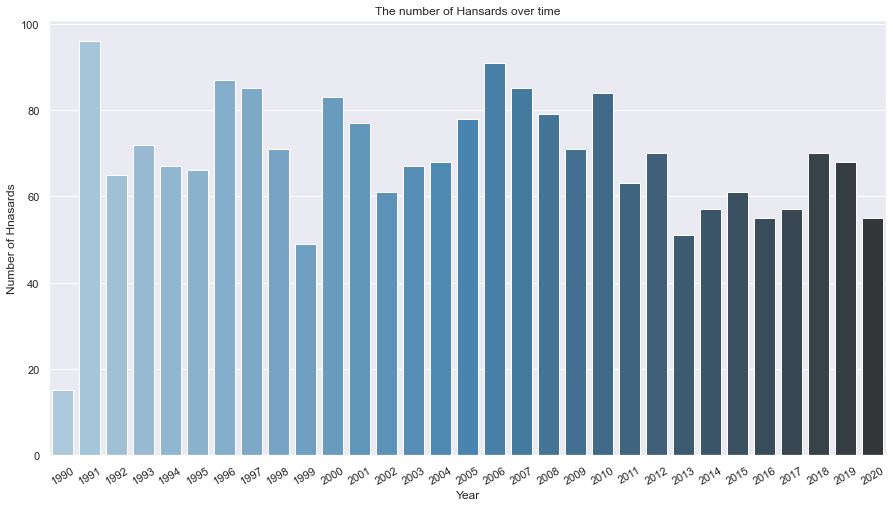

In [142]:
# The number of files by years
df_files = pd.DataFrame([[key, len(value)] for key, value in od.items()])
df_files.columns = ['year', 'number']

figure, ax = plt.subplots(figsize=(15, 8))

sns.barplot(x='year', y='number', palette="Blues_d", data=df_files)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Hansards")
ax.set_title("The number of Hansards over time")

In [6]:
def clean_text(text, unigrams=True, punctuation=True):
    '''Assume text is of type string. Convert text into lowercase.
    Remove stopwords and punctuations. Tokenize text into unigrams/bigrams. 
    
    Args:
        text (str): text to be tokenized.
        unigrams (bool): tokenize text into unigrams if True, bigrams if False.
        punctuation (bool): remove punctuation if True. 
        
    Returns:
        a list of tokens.
    '''
    # Covnvert text into lowercase
    text = text.lower()
    text = text.replace('&amp;', '&').replace('\n', ' ').replace('  ', ' ')
    
    # Remove url(s)  
    text = re.sub('https:\/\/[^\s]+', '', text)
    
    # Remove punctuations
    if punctuation == True:
        punctuations = string.punctuation + '‘’“”...'
        text = ''.join([char for char in text if char not in punctuations])
    
    if unigrams == True:   
        # Tokenize texts into unigrams
        tokens = text.split()
    else:
        # Tokenize texts into bigrams
        tokens = list(bigrams(text.split()))
    
    return tokens

In [ ]:
hansards_dict_tokens = {}

# Iterate through parliaments 
for key, docs in hansards_dict.items():
    # Iterate through hansards for each parliament 
    for doc in docs: 
        tokens = clean_text(doc)
        if key in hansards_dict_tokens:
            hansards_dict_tokens[key].append(tokens)
        else:
            hansards_dict_tokens[key] = [tokens]

In [169]:
# Get length of all documents for each parliament
tokens_length_dict = {}

for key, docs in hansards_dict_tokens.items():
    for doc in docs:
        length = len(doc)
        if key in tokens_length_dict:
            tokens_length_dict[key] += length
        else:
            tokens_length_dict[key] = length
            
tokens_length_dict

{'p08': 11471654,
 'p09': 12222640,
 'p10': 13702330,
 'p11': 16454424,
 'p12': 21288644,
 'p13': 18305502,
 'p14': 9759033}

In [ ]:
hansards_dict_by_year_tokens = {}

# Iterate through parliaments 
for key, docs in hansards_dict_by_year.items():
    # Iterate through hansards for each parliament 
    for doc in docs: 
        tokens = clean_text(doc)
        if key in hansards_dict_by_year_tokens:
            hansards_dict_by_year_tokens[key].append(tokens)
        else:
            hansards_dict_by_year_tokens[key] = [tokens]

In [150]:
# Get length of all documents for each year
tokens_length_dict = {}

for key, docs in hansards_dict_by_year_tokens.items():
    for doc in docs:
        length = len(doc)
        if key in tokens_length_dict:
            tokens_length_dict[key] += length
        else:
            tokens_length_dict[key] = length

Text(0.5, 1.0, 'The number of tokens over time')

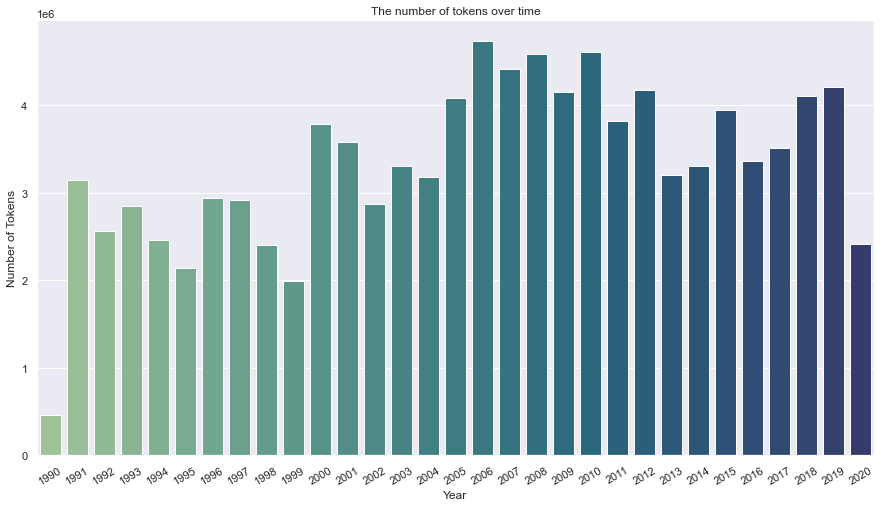

In [167]:
tokens_by_year = pd.DataFrame.from_dict(tokens_length_dict, orient='index')
tokens_by_year.reset_index(inplace=True)
tokens_by_year.columns = ["year", "tokens"]
tokens_by_year.sort_values(by=['year'], inplace=True)

figure, ax = plt.subplots(figsize=(15, 8))

sns.barplot(x="year", y="tokens", palette="crest", data=tokens_by_year)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Tokens")
ax.set_title("The number of tokens over time")

In [168]:
tokens_by_year

,year,tokens
4,1990,462996
0,1991,3143858
3,1992,2558015
1,1993,2844425
2,1994,2462360
5,1995,2135716
6,1996,2942892
7,1997,2912710
8,1998,2398316
9,1999,1987823


#  Linguistic shift of gender labels

- Kulkarni et al., 2014
    - Frequency based statistics 
    - Syntactic time series 
    - Distributional time series

## Frequency based shift
- normalized frequency 
- tf-idf

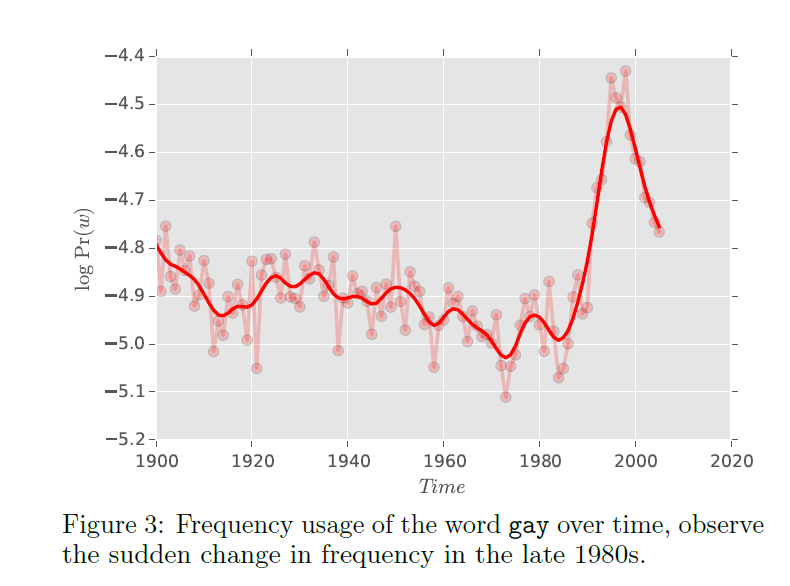

In [20]:
hansards_dict_tokens = {}

# Iterate through parliaments 
for key, docs in hansards_dict.items():
    # Iterate through hansards for each parliament 
    for doc in docs: 
        tokens = clean_text(doc)
        if key in hansards_dict_tokens:
            hansards_dict_tokens[key].append(tokens)
        else:
            hansards_dict_tokens[key] = [tokens]

In [21]:
hansards_dict_by_year_tokens = {}

# Iterate through parliaments 
for key, docs in hansards_dict_by_year.items():
    # Iterate through hansards for each parliament 
    for doc in docs: 
        tokens = clean_text(doc)
        if key in hansards_dict_by_year_tokens:
            hansards_dict_by_year_tokens[key].append(tokens)
        else:
            hansards_dict_by_year_tokens[key] = [tokens]

In [27]:
def get_freq(words, hansard, normalized = False):
    '''Calculate the frequency of a word or a list of words given tokenized texts.
    
    Args:
        words (str/list): a string of a word or a list of words
        hansard (dict): a dictionary containing tokenized hansards with years/parliaments as key
        normalized (bool): normalize the frequency by total words in each year/parliament if True. 
        
    Returns:
        list: A list of lists, with each element list containing word, its key and frequency
    '''
    # Calculate the frequencies of words in a list
    if isinstance(words, list):
        word_count = []
        for word in words:
            # Iterate through parliaments or years 
            for key, docs in hansard.items():
                count = 0
                total = 0
                # Iterate through documents for each parlm. or year 
                for doc in docs:
                    total += len(doc)
                    count += doc.count(word)
                if normalized == True:
                    count = count/total
                word_count.append([word, key, count])
      
    # Calculate the freq. of a single word 
    elif isinstance(words, str):   
        word_count = []
        # Iterate through parliaments or years 
        for key, docs in hansard.items():
            count = 0
            total = 0
            # Iterate through documents for each parlm. or year 
            for doc in docs:
                total += len(doc)
                count += doc.count(words)
            if normalized == True:
                count = count/total
            word_count.append([words, key, count])
    
    return word_count

In [35]:
df_freq = pd.DataFrame(get_freq("perempuan", hansards_dict_tokens))
df_freq = df_freq.append(pd.DataFrame(get_freq("lelaki", hansards_dict_tokens)))
df_freq.columns = ["word", "parliament", "frequency"]
df_freq

,word,parliament,frequency
0,perempuan,p08,527
1,perempuan,p09,606
2,perempuan,p10,771
3,perempuan,p11,988
4,perempuan,p12,812
5,perempuan,p13,627
6,perempuan,p14,218
0,lelaki,p08,581
1,lelaki,p09,819
2,lelaki,p10,1376


Text(0.5, 1.0, 'The frequency of gender words in each parliament')

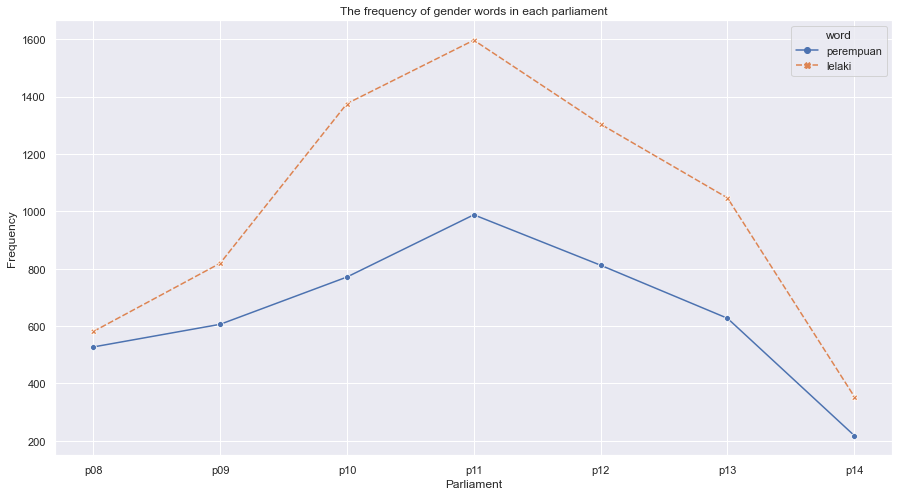

In [52]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='parliament', y='frequency', style = 'word',
             hue = 'word', markers = True, data=df_freq)

ax.set_xlabel("Parliament")
ax.set_ylabel("Frequency")
ax.set_title("The frequency of gender words in each parliament")

In [48]:
df_freq_norm = pd.DataFrame(get_freq("perempuan", hansards_dict_tokens, True))
df_freq_norm = df_freq_norm.append(pd.DataFrame(get_freq("lelaki", hansards_dict_tokens, True)))
df_freq_norm.columns = ["word", "parliament", "frequency"]
df_freq_norm

,word,parliament,frequency
0,perempuan,p08,0.000046
1,perempuan,p09,0.000050
2,perempuan,p10,0.000056
3,perempuan,p11,0.000060
4,perempuan,p12,0.000038
5,perempuan,p13,0.000034
6,perempuan,p14,0.000022
0,lelaki,p08,0.000051
1,lelaki,p09,0.000067
2,lelaki,p10,0.000100


Text(0.5, 1.0, 'The normalized frequency of gender words in each parliament')

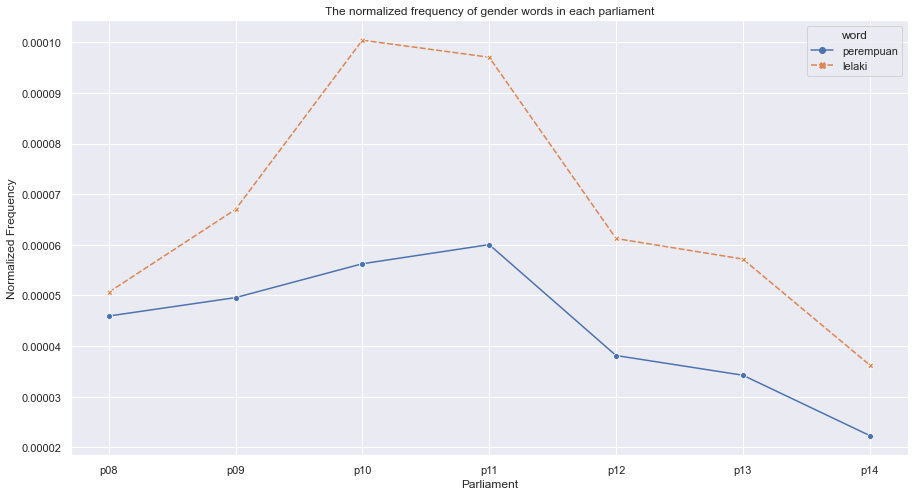

In [53]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='parliament', y='frequency', style = 'word',
             hue = 'word', markers = True, data=df_freq_norm)

ax.set_xlabel("Parliament")
ax.set_ylabel("Normalized Frequency")
ax.set_title("The normalized frequency of gender words in each parliament")

In [58]:
df_freq_year = pd.DataFrame(get_freq("perempuan", hansards_dict_by_year_tokens))
df_freq_year = df_freq_year.append(pd.DataFrame(get_freq("lelaki", hansards_dict_by_year_tokens)))

df_freq_year.columns = ["word", "year", "frequency"]
df_freq_year.sort_values(by=['year'], inplace=True)

df_freq_year.head(20)

,word,year,frequency
4,perempuan,1990,10
4,lelaki,1990,10
0,perempuan,1991,95
0,lelaki,1991,147
3,perempuan,1992,139
3,lelaki,1992,153
1,perempuan,1993,98
1,lelaki,1993,118
2,perempuan,1994,185
2,lelaki,1994,153


Text(0.5, 1.0, 'The frequency of gender words over time')

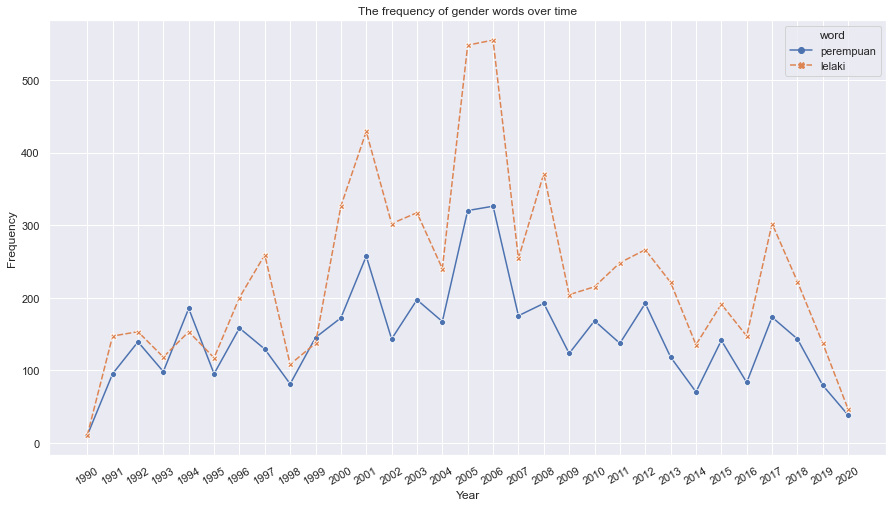

In [59]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Frequency")
ax.set_title("The frequency of gender words over time")

In [61]:
df_freq_year_norm = pd.DataFrame(get_freq("perempuan", hansards_dict_by_year_tokens, True))
df_freq_year_norm = df_freq_year_norm.append(pd.DataFrame(get_freq("lelaki", hansards_dict_by_year_tokens, True)))

df_freq_year_norm.columns = ["word", "year", "frequency"]
df_freq_year_norm.sort_values(by=['year'], inplace=True)

df_freq_year_norm.head(20)

,word,year,frequency
4,perempuan,1990,0.000022
4,lelaki,1990,0.000022
0,perempuan,1991,0.000030
0,lelaki,1991,0.000047
3,perempuan,1992,0.000054
3,lelaki,1992,0.000060
1,perempuan,1993,0.000034
1,lelaki,1993,0.000041
2,perempuan,1994,0.000075
2,lelaki,1994,0.000062


Text(0.5, 1.0, 'The normalized frequency of gender words over time')

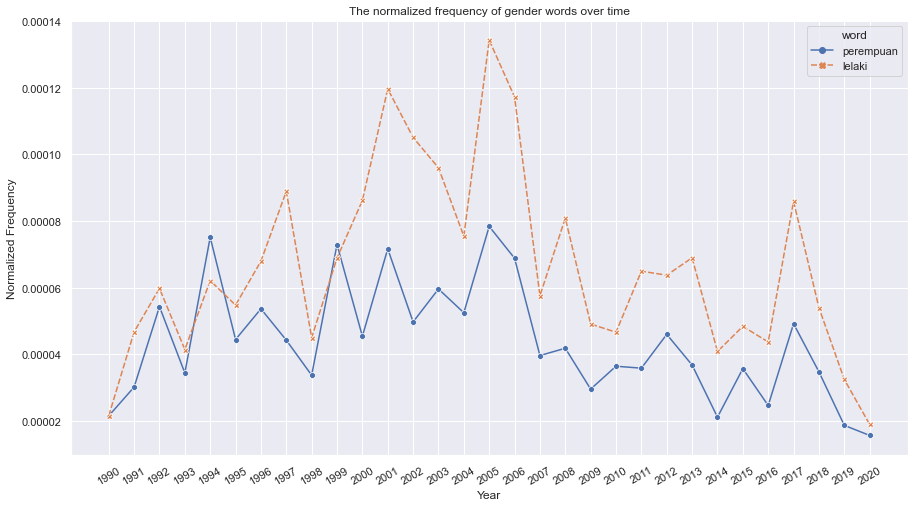

In [64]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year_norm)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Normalized Frequency")
ax.set_title("The normalized frequency of gender words over time")

Aziz (2019) - the highest collocate of wanita-lelaki/woman-man.
Although the collocation wanita-lelaki/woman-man shows a decline compared to the collocation
at the peak in P10, the frequency is still high. Thus, this is an indication that there are issues that
need further analysis to see why the use of lexical perempuan/woman seems ‘less important’
compared to wanita/woman in parliament. One explanation is provided by Hajar Abdul Rahim’s
study that shows that the lexical wanita/woman is often used in a more formal context while the
lexical perempuan/woman is more frequently used “to determine gender” (2005: 102) such as
budak/a child and murid/student’

In [65]:
df_freq = pd.DataFrame(get_freq("wanita", hansards_dict_tokens))
df_freq = df_freq.append(pd.DataFrame(get_freq("lelaki", hansards_dict_tokens)))
df_freq.columns = ["word", "parliament", "frequency"]
df_freq

,word,parliament,frequency
0,wanita,p08,1469
1,wanita,p09,3215
2,wanita,p10,6372
3,wanita,p11,5698
4,wanita,p12,8088
5,wanita,p13,7000
6,wanita,p14,2789
0,lelaki,p08,581
1,lelaki,p09,819
2,lelaki,p10,1376


Text(0.5, 1.0, 'The frequency of gender words in each parliament')

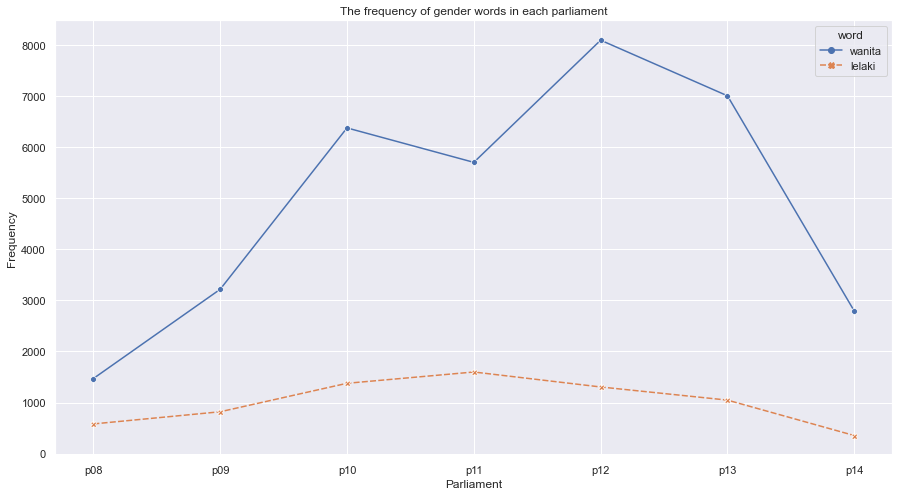

In [66]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='parliament', y='frequency', style = 'word',
             hue = 'word', markers = True, data=df_freq)

ax.set_xlabel("Parliament")
ax.set_ylabel("Frequency")
ax.set_title("The frequency of gender words in each parliament")

In [67]:
df_freq_norm = pd.DataFrame(get_freq("wanita", hansards_dict_tokens, True))
df_freq_norm = df_freq_norm.append(pd.DataFrame(get_freq("lelaki", hansards_dict_tokens, True)))
df_freq_norm.columns = ["word", "parliament", "frequency"]
df_freq_norm

,word,parliament,frequency
0,wanita,p08,0.000128
1,wanita,p09,0.000263
2,wanita,p10,0.000465
3,wanita,p11,0.000346
4,wanita,p12,0.000380
5,wanita,p13,0.000382
6,wanita,p14,0.000286
0,lelaki,p08,0.000051
1,lelaki,p09,0.000067
2,lelaki,p10,0.000100


Text(0.5, 1.0, 'The normalized frequency of gender words in each parliament')

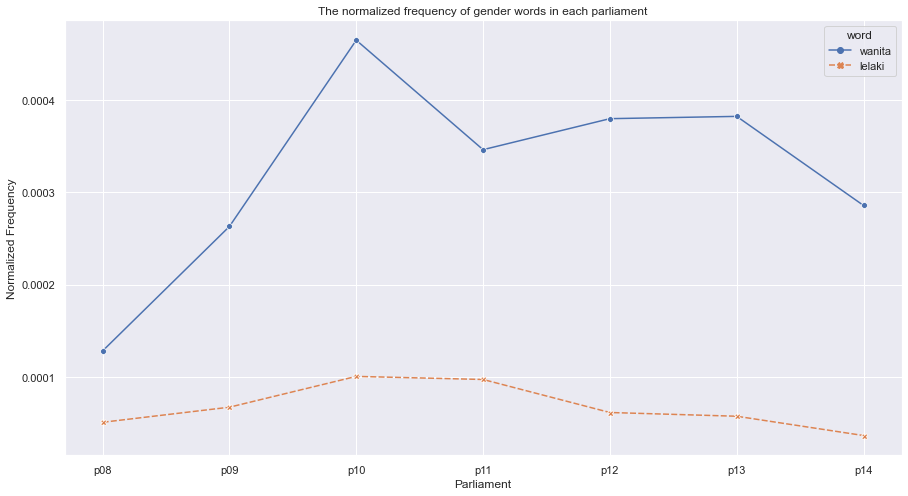

In [71]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='parliament', y='frequency', style = 'word',
             hue = 'word', markers = True, data=df_freq_norm)

ax.set_xlabel("Parliament")
ax.set_ylabel("Normalized Frequency")
ax.set_title("The normalized frequency of gender words in each parliament")

In [72]:
df_freq_year = pd.DataFrame(get_freq("wanita", hansards_dict_by_year_tokens))
df_freq_year = df_freq_year.append(pd.DataFrame(get_freq("lelaki", hansards_dict_by_year_tokens)))

df_freq_year.columns = ["word", "year", "frequency"]
df_freq_year.sort_values(by=['year'], inplace=True)

df_freq_year.head(20)

,word,year,frequency
4,wanita,1990,71
4,lelaki,1990,10
0,wanita,1991,560
0,lelaki,1991,147
3,wanita,1992,306
3,lelaki,1992,153
1,wanita,1993,235
1,lelaki,1993,118
2,wanita,1994,297
2,lelaki,1994,153


Text(0.5, 1.0, 'The frequency of gender words over time')

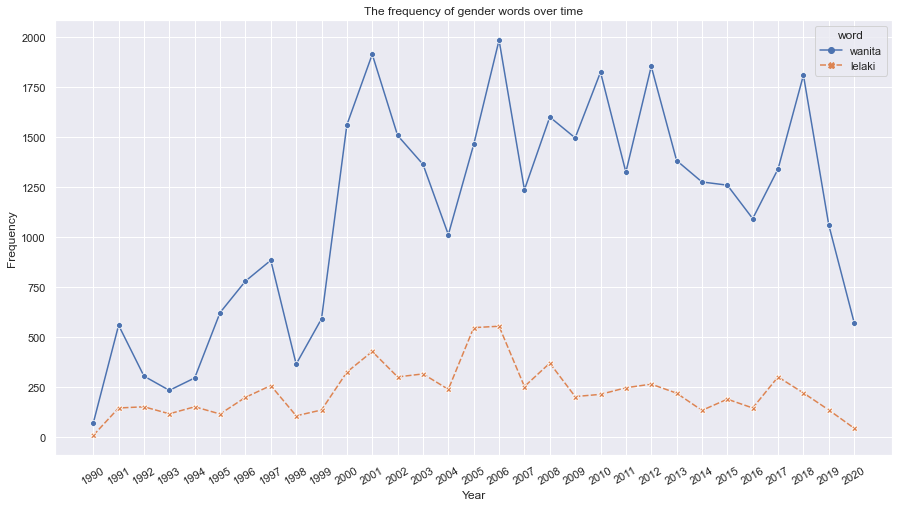

In [73]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Frequency")
ax.set_title("The frequency of gender words over time")

In [74]:
df_freq_year_norm = pd.DataFrame(get_freq("wanita", hansards_dict_by_year_tokens, True))
df_freq_year_norm = df_freq_year_norm.append(pd.DataFrame(get_freq("lelaki", hansards_dict_by_year_tokens, True)))

df_freq_year_norm.columns = ["word", "year", "frequency"]
df_freq_year_norm.sort_values(by=['year'], inplace=True)

df_freq_year_norm.head(20)

,word,year,frequency
4,wanita,1990,0.000153
4,lelaki,1990,0.000022
0,wanita,1991,0.000178
0,lelaki,1991,0.000047
3,wanita,1992,0.000120
3,lelaki,1992,0.000060
1,wanita,1993,0.000083
1,lelaki,1993,0.000041
2,wanita,1994,0.000121
2,lelaki,1994,0.000062


Text(0.5, 1.0, 'The normalized frequency of gender words over time')

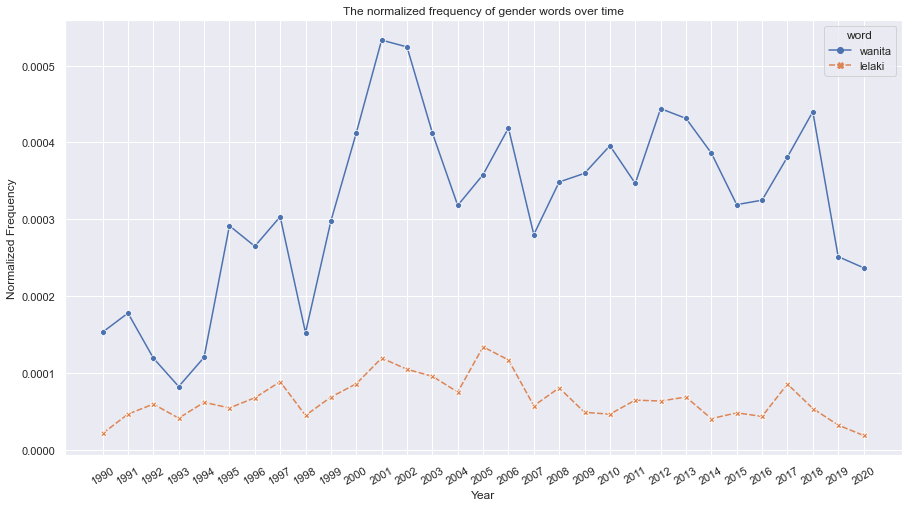

In [75]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year_norm)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Normalized Frequency")
ax.set_title("The normalized frequency of gender words over time")

In [413]:
female_nouns = ['perempuan', 'wanita', 'isteri', 'gadis', 'datin', 'pemudi']

df_freq_year = pd.DataFrame(get_freq(female_nouns, hansards_dict_by_year_tokens))

df_freq_year.columns = ["word", "year", "frequency"]
df_freq_year.sort_values(by=['year'], inplace=True)

df_freq_year.head(5)

,word,year,frequency
128,datin,1990,74
97,gadis,1990,7
4,perempuan,1990,10
159,pemudi,1990,0
66,isteri,1990,30


Text(0.5, 1.0, 'The frequency of female labels over time')

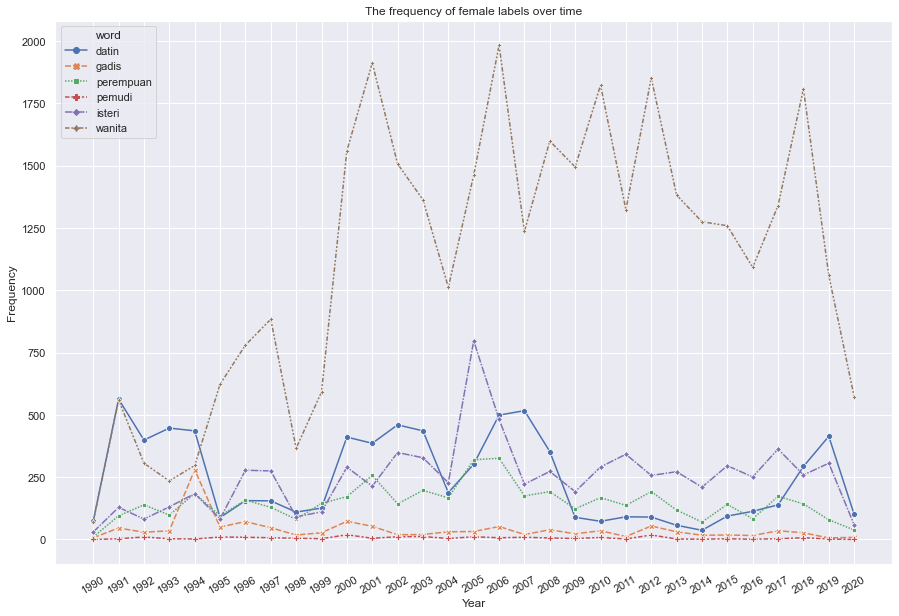

In [414]:
figure, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Frequency")
ax.set_title("The frequency of female labels over time")

In [415]:
df_freq_year_norm = pd.DataFrame(get_freq(female_nouns, hansards_dict_by_year_tokens, True))

df_freq_year_norm.columns = ["word", "year", "frequency"]
df_freq_year_norm.sort_values(by=['year'], inplace=True)

df_freq_year_norm.head(5)

,word,year,frequency
128,datin,1990,0.000160
97,gadis,1990,0.000015
4,perempuan,1990,0.000022
159,pemudi,1990,0.000000
66,isteri,1990,0.000065


Text(0.5, 1.0, 'The normalized frequency of female labels over time')

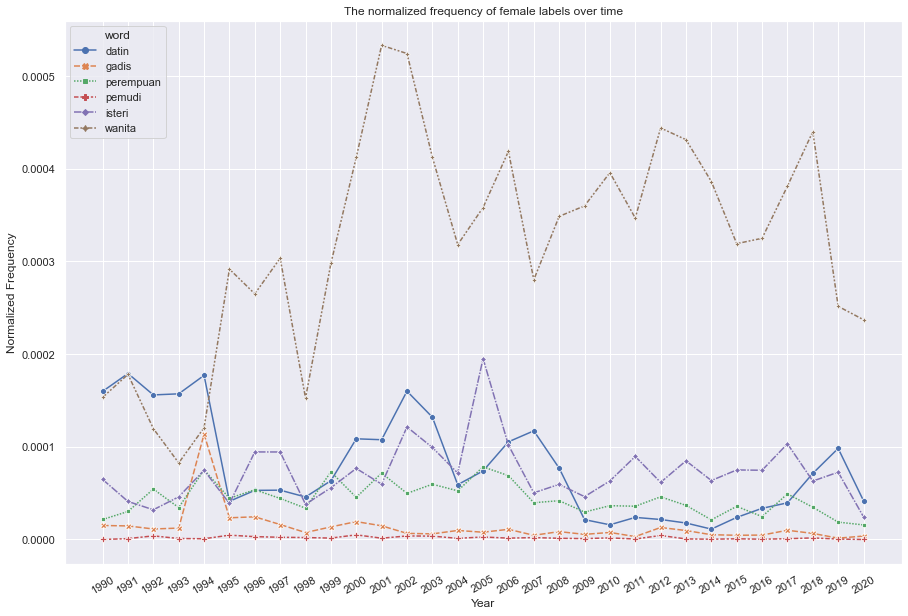

In [416]:
figure, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year_norm)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Normalized Frequency")
ax.set_title("The normalized frequency of female labels over time")

In [174]:
male_nouns = ['lelaki', 'male', 'laki', 'suami', 'pemuda', 'leiaki', 'datuk']

df_freq_year = pd.DataFrame(get_freq(male_nouns, hansards_dict_by_year_tokens))

df_freq_year.columns = ["word", "year", "frequency"]
df_freq_year.sort_values(by=['year'], inplace=True)

df_freq_year.head(5)

,word,year,frequency
97,suami,1990,10
35,male,1990,0
190,datuk,1990,350
66,laki,1990,0
128,pemuda,1990,12


Text(0.5, 1.0, 'The frequency of male labels over time')

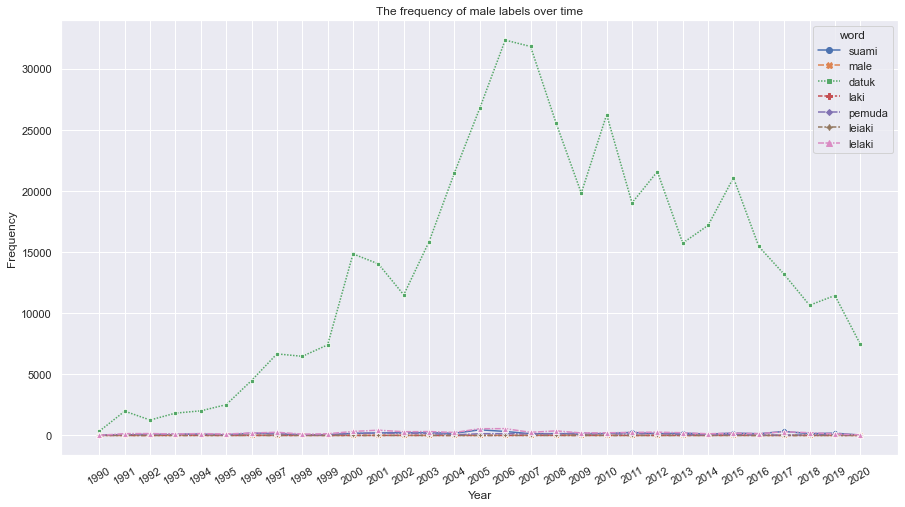

In [175]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Frequency")
ax.set_title("The frequency of male labels over time")

In [176]:
df_freq_year_norm = pd.DataFrame(get_freq(male_nouns, hansards_dict_by_year_tokens, True))

df_freq_year_norm.columns = ["word", "year", "frequency"]
df_freq_year_norm.sort_values(by=['year'], inplace=True)

df_freq_year_norm.head(5)

,word,year,frequency
97,suami,1990,0.000022
35,male,1990,0.000000
190,datuk,1990,0.000756
66,laki,1990,0.000000
128,pemuda,1990,0.000026


Text(0.5, 1.0, 'The normalized frequency of male labels over time')

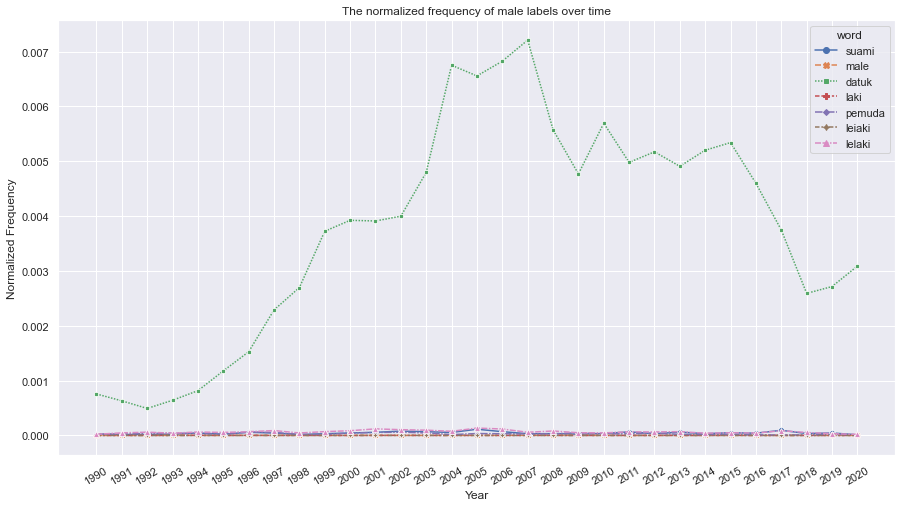

In [177]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year_norm)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Normalized Frequency")
ax.set_title("The normalized frequency of male labels over time")

In [422]:
# Remove datuk 
male_nouns = ['lelaki', 'male', 'laki', 'suami', 'pemuda', 'leiaki']

df_freq_year = pd.DataFrame(get_freq(male_nouns, hansards_dict_by_year_tokens))

df_freq_year.columns = ["word", "year", "frequency"]
df_freq_year.sort_values(by=['year'], inplace=True)

df_freq_year.head(5)

,word,year,frequency
128,pemuda,1990,12
97,suami,1990,10
4,lelaki,1990,10
159,leiaki,1990,0
66,laki,1990,0


Text(0.5, 1.0, "The frequency of male labels (without 'datuk') over time")

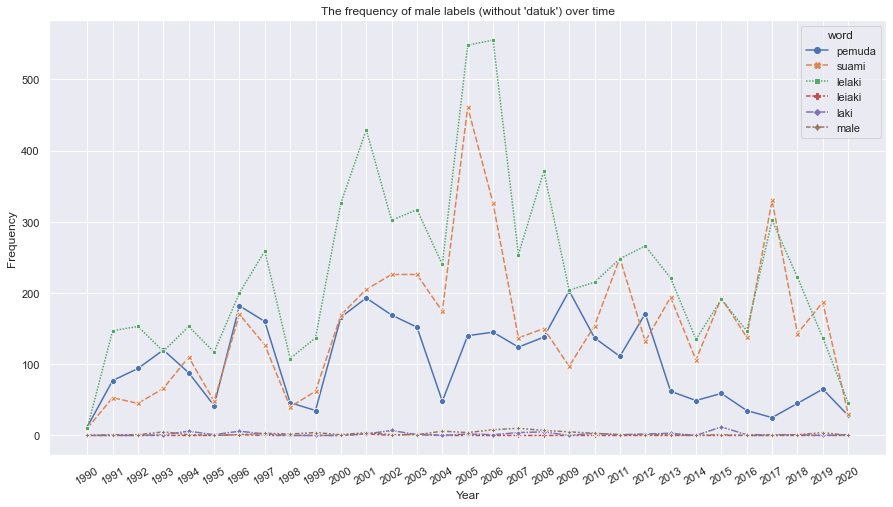

In [423]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Frequency")
ax.set_title("The frequency of male labels (without 'datuk') over time")

In [424]:
df_freq_year_norm = pd.DataFrame(get_freq(male_nouns, hansards_dict_by_year_tokens, True))

df_freq_year_norm.columns = ["word", "year", "frequency"]
df_freq_year_norm.sort_values(by=['year'], inplace=True)

df_freq_year_norm.head(5)

,word,year,frequency
128,pemuda,1990,0.000026
97,suami,1990,0.000022
4,lelaki,1990,0.000022
159,leiaki,1990,0.000000
66,laki,1990,0.000000


Text(0.5, 1.0, "The normalized frequency of male labels (without 'datuk') over time")

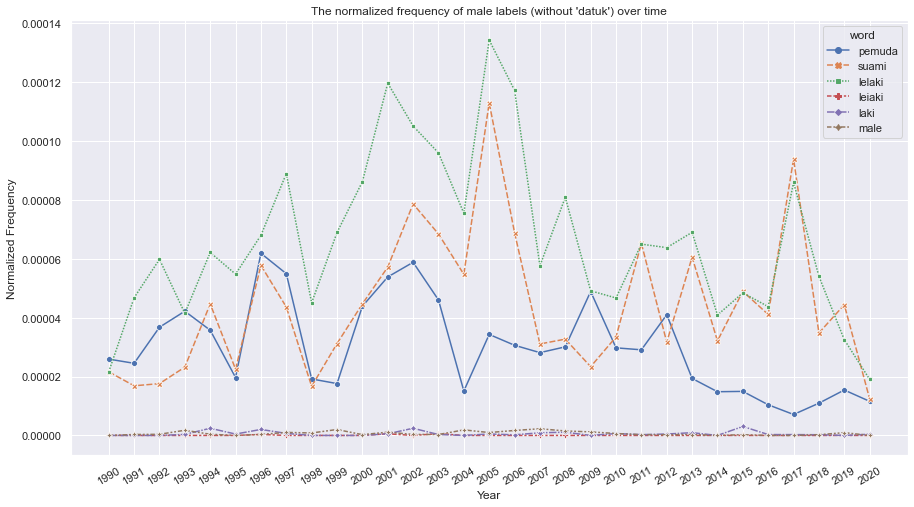

In [425]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year_norm)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Normalized Frequency")
ax.set_title("The normalized frequency of male labels (without 'datuk') over time")

In [183]:
df_freq_year = pd.DataFrame(get_freq("datin", hansards_dict_by_year_tokens))
df_freq_year = df_freq_year.append(pd.DataFrame(get_freq("datuk", hansards_dict_by_year_tokens)))

df_freq_year.columns = ["word", "year", "frequency"]
df_freq_year.sort_values(by=['year'], inplace=True)

df_freq_year.head(20)

,word,year,frequency
4,datin,1990,74
4,datuk,1990,350
0,datin,1991,563
0,datuk,1991,1983
3,datin,1992,399
3,datuk,1992,1259
1,datin,1993,447
1,datuk,1993,1825
2,datin,1994,436
2,datuk,1994,2011


Text(0.5, 1.0, "The frequency of 'datuk' and 'datin' over time")

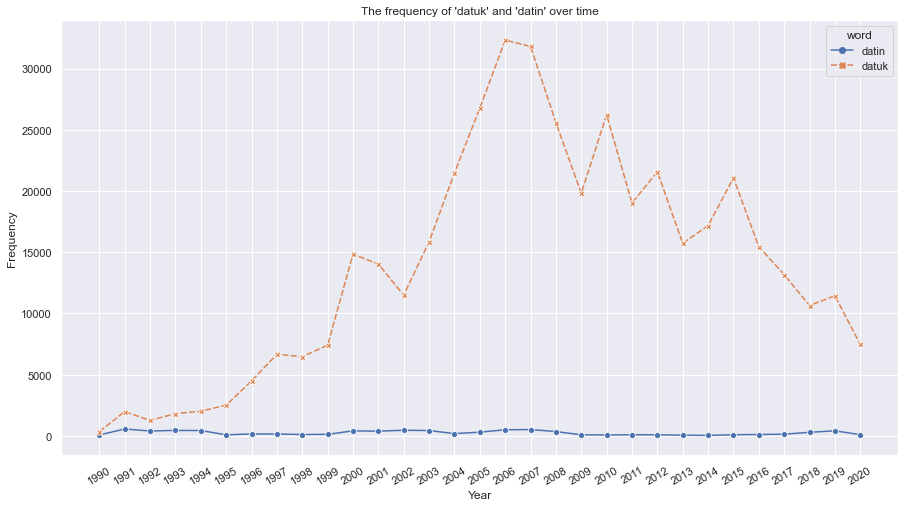

In [184]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Frequency")
ax.set_title("The frequency of 'datuk' and 'datin' over time")

In [185]:
df_freq_year_norm = pd.DataFrame(get_freq("datin", hansards_dict_by_year_tokens, True))
df_freq_year_norm = df_freq_year_norm.append(pd.DataFrame(get_freq("datuk", hansards_dict_by_year_tokens, True)))

df_freq_year_norm.columns = ["word", "year", "frequency"]
df_freq_year_norm.sort_values(by=['year'], inplace=True)

df_freq_year_norm.head(20)

,word,year,frequency
4,datin,1990,0.000160
4,datuk,1990,0.000756
0,datin,1991,0.000179
0,datuk,1991,0.000631
3,datin,1992,0.000156
3,datuk,1992,0.000492
1,datin,1993,0.000157
1,datuk,1993,0.000642
2,datin,1994,0.000177
2,datuk,1994,0.000817


Text(0.5, 1.0, "The normalized frequency of 'datuk' and 'datin'  over time")

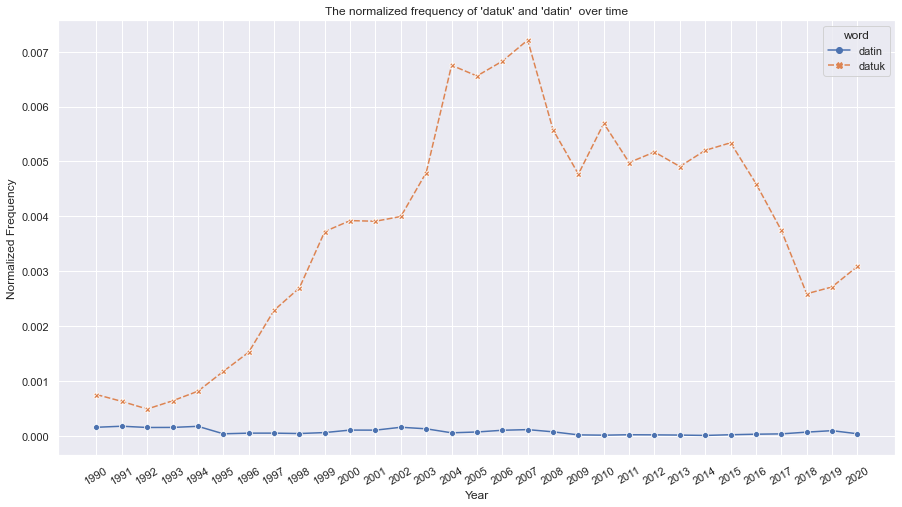

In [186]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='frequency', style='word',
             hue='word', markers=True, data=df_freq_year_norm)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Normalized Frequency")
ax.set_title("The normalized frequency of 'datuk' and 'datin'  over time")

## Syntactic time series


## Semantic shift: Word Embeddings

References: 
- Different uses and visualization:https://ccgilroy.github.io/community-discourse/historical-change.html

### Train word2vec model

In [76]:
def train_word2vec(hansard):
    '''Train word embeddings given a list of texts'''
    # Preprocess the data 
    text = []
    for doc in hansard:
        text.append(simple_preprocess(doc, min_len=1))
    
    # Train the model 
    model = Word2Vec(sentences=text, size=50, window=5, 
                     min_count=5, workers=3, sg=1,
                     hs=0, negative=5, iter=10)
    return model 

In [77]:
# Train model on each hansard 
word2vec_dict = {}

for key, hansard in hansards_dict.items():
    model = train_word2vec(hansard)
    word2vec_dict[key] = model

In [78]:
# Train model by years 
word2vec_dict_by_year = {}

for key, hansard in hansards_dict_by_year.items():
    model = train_word2vec(hansard)
    word2vec_dict_by_year[key] = model

In [80]:
# Save models 
pickle.dump(word2vec_dict, open('../../models/word2vec_dict_simple', 'wb'))
pickle.dump(word2vec_dict_by_year, open('../../models/word2vec_dict_by_year_simple', 'wb'))

Kulkarni et al. (2014): Given a temporal corpora
C that is created over a time span S, we divide the corpora
into n snapshots Ct each of period length P. We build a
common vocabulary V by **intersecting the word dictionaries
that appear in all the snapshots** (i.e, we track the same word
set across time). This eliminates trivial examples of word
usage shift from words which appear or vanish throughout
the corpus.

### Import trained models

In [79]:
word2vec_dict

{'p08': <gensim.models.word2vec.Word2Vec object at 0x000001BD096A9E80>, 'p09': <gensim.models.word2vec.Word2Vec object at 0x000001BD0834E760>, 'p10': <gensim.models.word2vec.Word2Vec object at 0x000001BD35F43AC0>, 'p11': <gensim.models.word2vec.Word2Vec object at 0x000001BD3D1D2FD0>, 'p12': <gensim.models.word2vec.Word2Vec object at 0x000001BD484C7D00>, 'p13': <gensim.models.word2vec.Word2Vec object at 0x000001BD6AF710A0>, 'p14': <gensim.models.word2vec.Word2Vec object at 0x000001BD6B93D3D0>}

In [83]:
# Load trained models
word2vec_dict = pickle.load(open('../../models/word2vec_dict_simple', 'rb'))
word2vec_dict_by_year = pickle.load(open('../../models/word2vec_dict_by_year_simple', 'rb'))

In [85]:
print(word2vec_dict['p14'].corpus_count)
print(word2vec_dict['p14'].wv.vectors.shape)

173
(21436, 50)


In [86]:
word2vec_dict['p14'].wv['wanita']

array([ 0.01084126, -1.151592  , -0.03674325,  0.51036274,  0.3524361 ,
       -0.28053313, -0.06888022, -0.5601805 ,  0.82004684,  0.73450446,
       -0.12267882, -0.11042617,  1.1553277 ,  0.9756613 , -0.23459876,
        0.11355986, -0.34860346,  0.22580282, -0.98162276,  0.08651571,
       -0.5101919 , -0.16254848,  0.49784803,  0.06552012, -0.5403257 ,
        0.16211788, -0.06266923,  0.26317146, -0.21338269, -0.28699642,
        0.05272949,  0.5768069 ,  0.4905503 ,  0.29614517, -0.33789623,
       -0.08968341, -0.07857943,  0.7408275 ,  0.44043303,  0.17256519,
        0.8992229 , -0.5360945 , -0.9921009 , -0.05860668,  0.761425  ,
        0.10880384, -0.12543188,  0.12048979,  1.0576016 ,  0.36981815],
      dtype=float32)

In [87]:
word2vec_dict['p14'].wv.most_similar("wanita")

[('keluarga', 0.9103316068649292), ('masyarakat', 0.88210129737854), ('kpwkm', 0.7357637882232666), ('hannah', 0.7357456684112549), ('yeoh', 0.7322217226028442), ('muflis', 0.7134740948677063), ('segambut', 0.7093077301979065), ('latent', 0.7074115872383118), ('pembangunan', 0.6942329406738281), ('dayak', 0.693739116191864)]

In [88]:
word2vec_dict['p14'].wv.most_similar("perempuan")

[('lelaki', 0.8054656982421875), ('dikahwinkan', 0.7772188782691956), ('balu', 0.7757924199104309), ('bapanya', 0.7627581357955933), ('ayah', 0.7539925575256348), ('papa', 0.7518845200538635), ('pasangan', 0.7518264055252075), ('mengemis', 0.7474806904792786), ('yatim', 0.7469517588615417), ('mengenali', 0.7425348162651062)]

In [89]:
word2vec_dict['p14'].wv.most_similar("lelaki")

[('perempuan', 0.8054657578468323), ('suami', 0.7972849607467651), ('jantina', 0.7897061109542847), ('papa', 0.7726162075996399), ('dewasa', 0.7587782740592957), ('muflis', 0.7584165334701538), ('pasangannya', 0.7544224262237549), ('statistiknya', 0.7541758418083191), ('merogol', 0.7482816576957703), ('pasangan', 0.7479974031448364)]

In [12]:
# Get vectors for females and bias 
vec_female_nouns = [w2v_model1.wv[word] for word in female_nouns]
vec_status = [w2v_model1.wv[word] for word in status]
vec_occupations = [w2v_model1.wv[word] for word in occupations]

In [13]:
def get_average_distance(vec1, vec2, embeddings):
    '''Return the average cosine distance between two lists of vectors'''
    cosine_dist = [1-embeddings.wv.similarity(x, y) for x in vec1 for y in vec2]
    return sum(cosine_dist)/len(cosine_dist)

In [14]:
print(get_average_distance(['perempuan'], occupations, w2v_model1))
print(get_average_distance(['lelaki'], occupations, w2v_model1))

0.5102990716695786
0.5556630343198776


In [15]:
print(get_average_distance(female_nouns, occupations, w2v_model1))
print(get_average_distance(male_nouns, occupations, w2v_model1))
# male nouns are closer to occupations like pelacur/guru? 

0.4845986078892435
0.47475896775722504


In [55]:
dist = []

for embeddings in word2vec_dict.values():
    dist_female = get_average_distance(['perempuan'], ['terpengaruh'], embeddings)
    dist_male = get_average_distance(['lelaki'], ['terpengaruh'], embeddings)
    dist.append([dist_female, dist_male])
    
df = pd.DataFrame(dist, 
                  columns = ['dist_female', 'dist_male'],
                  index = word2vec_dict.keys())
df

,dist_female,dist_male
hansard_p11,0.559471,0.537388
hansard_p12,0.530844,0.505878
hansard_p13,0.662856,0.517723
hansard_p14,0.611630,0.650906


<AxesSubplot:>

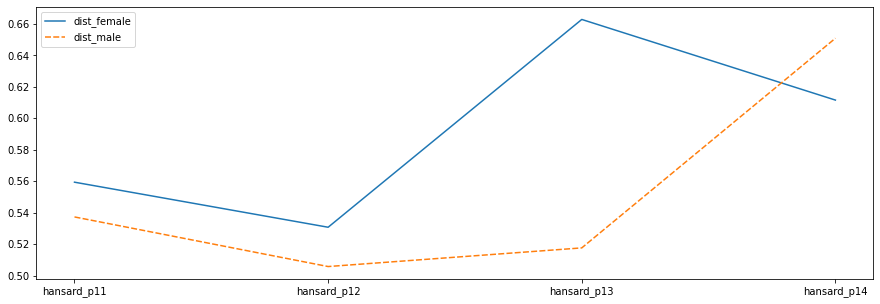

In [56]:
figure, axes = plt.subplots(figsize=(15, 5))
sns.lineplot(data=df)

In [17]:
print(get_average_distance(female_nouns, status, w2v_model1))
print(get_average_distance(male_nouns, status, w2v_model1))

0.40865587975297657
0.44664802998304365


In [57]:
print(get_average_distance(['perempuan'], ['terpengaruh'], w2v_model1))
print(get_average_distance(['lelaki'], ['terpengaruh'], w2v_model1))

0.6120504438877106
0.638123482465744


### Self similarity

- Refer to Kulkarni et al. (2014)

In [114]:
def get_self_dist(word, models, baseline):
    '''Compute the cosine distance of a word vector with its vectors in other years/parliaments.
    
    Args:
        words (str): a string of a word
        models (dict): a dictionary containing multiple trained word2vec models using gensim
        baseline (str): the year or the parliament which acts as the baseline 
        
    Returns:
        list: A list of lists, with each element list containing word, dict_key and distance
    '''
    self_dist = []
    
    for key in models:
        cos_sim = np.dot(unitvec(models[baseline].wv[word]), 
                         unitvec(models[key].wv[word]))
        cos_dist = 1 - cos_sim
        self_dist.append([word, key, cos_dist])
    
    return self_dist

In [187]:
df_self = pd.DataFrame(get_self_dist('wanita', word2vec_dict_by_year, '1991'))
#df_self = df_self.append(pd.DataFrame(get_self_dist('perempuan', word2vec_dict_by_year, '1991')))
df_self = df_self.append(pd.DataFrame(get_self_dist('lelaki', word2vec_dict_by_year, '1991')))

df_self.columns = ['word', 'year', 'distance']
df_self = df_self.loc[df_self['year']!='1990', ]
df_self.sort_values(by=['year'], inplace=True)

df_self

,word,year,distance
0,wanita,1991,0.000000
0,lelaki,1991,0.000000
3,wanita,1992,0.408464
3,lelaki,1992,0.438766
1,wanita,1993,0.473422
1,lelaki,1993,0.485917
2,wanita,1994,0.669965
2,lelaki,1994,0.587383
5,wanita,1995,0.642475
5,lelaki,1995,0.646337


Text(0.5, 1.0, 'Semantic shift of gender labels over time')

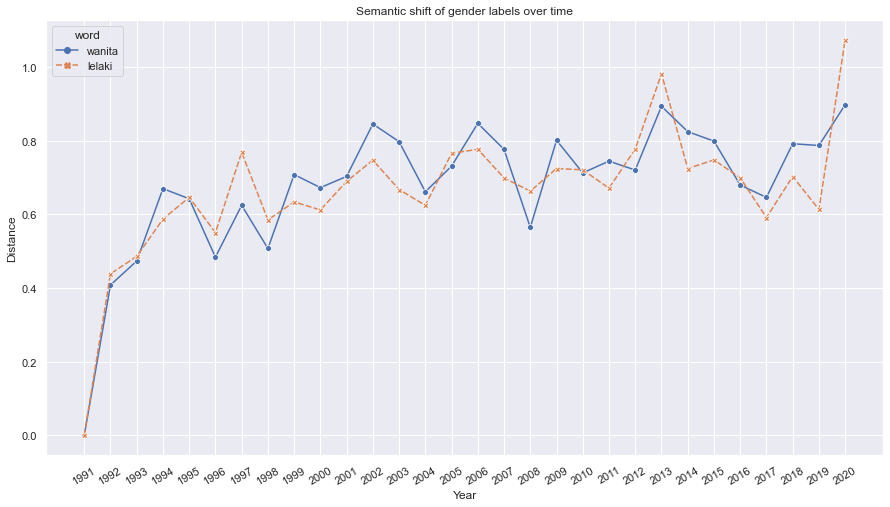

In [188]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='distance', style='word',
             hue='word', markers=True, data=df_self)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Distance")
ax.set_title("Semantic shift of gender labels over time")

### Words most similar to female nouns 

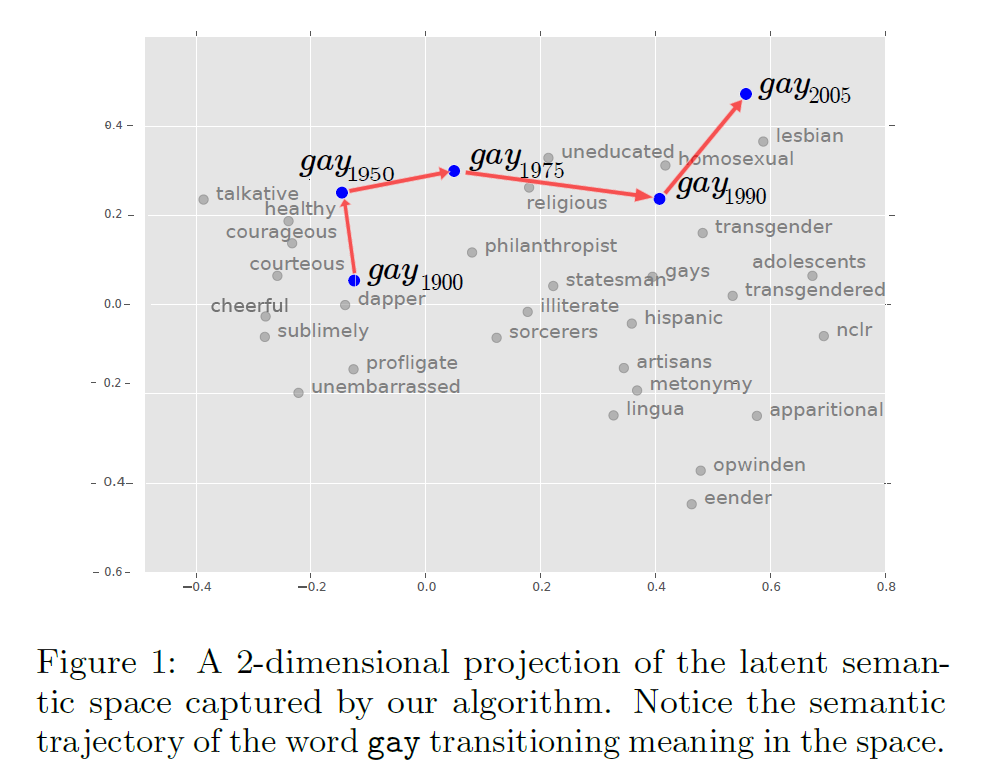

In [90]:
hist_wanita = []
for year in word2vec_dict_by_year:
    w, s = zip(*word2vec_dict_by_year[year].wv.most_similar("wanita", topn=20))
    hist_wanita.append(pd.Series(data=w, name=year))
    
pd.DataFrame(hist_wanita).sort_index()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1990,pencarian,menghadkan,sebelah,slogan,mencari,mengecam,liberal,mata,memudahkan,polisi,menakut,menyekat,pekerjanya,dimakan,teguh,ganti,ternakan,pendeposit,menolong,rangkaian
1991,lelaki,uniform,terjebak,bekerja,penggajian,rumahtangga,menggaji,mustahaknya,menyedarkan,menganiaya,responsif,bawahan,khalayak,memakai,perkeranian,sedekah,inferiority,beratkan,mengenepikan,berkelayakan
1992,lelaki,pengemis,pergaulan,pendengaran,seperii,wargatua,bersendirian,cacat,kebajikan,dedikasi,hawa,pendidik,diperjuangkan,permasalahan,wartawan,etnik,ertikata,sukarelawan,bersubahat,cam
1993,pelacuran,penglihatan,membabitkan,spastik,kaum,penagih,melepak,pendengaran,setempat,berpengaruh,muridnya,kesultanan,penghibur,buta,juvana,banduan,comfort,gadis,jeli,tetangga
1994,hoki,jurulatih,badminton,menembak,pelayan,lelaki,badmin,puashati,berpakaian,bayi,penyelamat,pentadbirannya,mempamerkan,dewasa,syarahan,mempakan,dilatih,berkemahiran,mementingkan,pendidik
1995,komuniti,gadis,remaja,mengharumkan,saling,penaja,keluarga,kehadiran,terbentuk,terkecuali,disiplin,berkeluarga,menceburkan,maruah,simati,diskriminasi,membimbing,sedunia,berkelakuan,mengandung
1996,kaum,kepimpinan,menghinakan,lelaki,diwakili,psikologi,sasar,rumahtangga,terpelihara,pesara,hatta,paderi,ngo,ilmuan,penga,kesedaran,lapisan,penghayatan,atlit,tionghua
1997,lelaki,kaum,tradisi,perempuan,menekan,menggerunkan,toleransi,sosialnya,latar,marilah,memimpin,seluruhnya,serbi,penghormatan,kepartian,maruah,warisan,muhibah,mendiskriminasi,nafkah
1998,lelaki,gadis,fasilitator,pembuat,kaum,jheoa,motivasi,menceburkan,penggerak,jkk,keluarga,era,dilatih,penyelaras,jaringan,penghayatan,umbi,pertak,flkiran,persefahaman
1999,lelaki,penggubal,kaunselor,diiringi,ngos,fahaman,memperjuangkan,gadis,orang,disukai,melarikan,kaum,pemberitahuan,ahlinya,cacat,kadazan,dihasut,mengandung,kecewa,moral


In [91]:
hist_prp = []
for year in word2vec_dict_by_year:
    w, s = zip(*word2vec_dict_by_year[year].wv.most_similar("perempuan", topn=20))
    hist_prp.append(pd.Series(data=w, name=year))
    
pd.DataFrame(hist_prp).sort_index()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1990,hakim,ditakrif,inro,hs,angkasa,tamb,captive,menderita,dingin,mempertikaikan,menghukum,bomba,mlm,portfolio,mengalakan,seliaan,jijik,dcmikian,pbbmt,dipcrlukan
1991,ramaikah,aniaya,lelaki,orangkah,buta,dilucutkan,terencat,mencederakan,tok,abuse,specialist,kecacatan,menganiaya,punjabi,persembahan,menanjung,rnenyatakan,diseludup,memukul,berbangsa
1992,lelaki,talon,bertukar,guru,umurnya,memukul,disandang,berpakaian,ditimpa,penjaga,komposisi,etnik,pelaj,meninggal,muridnya,uzur,lulus,serban,pengetua,dilatih
1993,lelaki,katanya,jadilah,berkahwin,lahirnya,umurnya,rogol,emak,anjing,beriman,gila,dibunuh,genghis,sarkas,diangkat,terkorban,curi,mamak,dirogol,bertaubat
1994,hamil,mendera,suami,sayangkan,isteri,teraniaya,berkelayakan,ayah,merogol,lelaki,bapa,bersekolah,penolakan,keluarga,mengandung,muridnya,ibu,selamatkan,berpangkat,dewasa
1995,lelaki,berumur,seekar,dilahirkan,kerani,soalnya,cacat,menembak,huang,umur,suaminya,dibunuh,menurun,membunuh,menyalah,dianggapkan,mencederakan,mati,newspaper,ertinya
1996,lelaki,berusia,sejuta,berkelahi,memukul,paderi,tionghua,dirogol,papa,orang,ielaki,ertinya,kemarahan,pelacur,lawan,seringgit,buta,bergaji,budak,berumur
1997,lelaki,punk,laki,berbangsa,beradik,kahwin,contob,aku,tradisi,bayangkanlah,berwasiat,lekeh,menantu,suami,suaminya,kemaluan,isterinya,adik,kamu,berkahwin
1998,lelaki,tua,berumur,umur,dilahirkan,akal,banduan,ikat,terencat,fasilitator,penjawat,isteri,kelahiran,beranak,diajarkan,lulus,penjaga,mernasuki,pertak,selarna
1999,lelaki,tua,berumur,peduli,sesat,mengandung,berceramah,bersalin,kubur,sembahyang,kerat,dok,menetap,mencuba,dicantumkan,agarna,nabi,bunuh,macarn,beranak


In [97]:
hist_prp = []
for year in word2vec_dict_by_year:
    w, s = zip(*word2vec_dict_by_year[year].wv.most_similar("isteri", topn=20))
    hist_prp.append(pd.Series(data=w, name=year))
    
pd.DataFrame(hist_prp).sort_index()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1990,hanyalah,menuntut,suami,denda,kenakan,menguatkuasakan,minggu,menghentikan,timber,daripadanya,minuman,dinaikkan,dihapuskan,sckali,semestinya,kuota,pergerakan,digulung,disyaki,harganya
1991,suami,angkat,maranya,sumpah,qualified,anaknya,penjaganya,seboleh,yatim,waris,pencennya,mercka,kasihan,bolehnya,sanak,bapanya,belul,bendanya,menembak,menegur
1992,suami,pasangan,dibunuh,menginap,ibadah,yatim,askar,upahan,daif,suci,diusir,nakal,reputasi,hukumnya,digelarkan,membunuh,jihad,bapanya,penjaga,mengedar
1993,suami,cucu,berkahwin,lelaki,anaknya,seorang,kuliah,dibunuh,perempuan,adik,loh,dilahirkan,mati,menyerah,syarikatnya,gadis,namanya,nafkah,beriman,menyaman
1994,suami,nenek,sayangkan,cucu,latih,anaknya,merogol,holeh,mendera,isterinya,keluarganya,diselamatkan,sehagai,teman,teraniaya,pasangan,lelaki,perempuan,jogging,mempakan
1995,suami,alamat,banduan,askar,rajin,bercuti,pindah,nikmat,berpangkat,mengandung,jasa,mereka,menggaji,kehajikan,mabuk,dikurniakan,percuma,menikah,tukar,kasihan
1996,suami,nafkah,memukul,ditinggal,perkahwinan,batin,berkahwin,balu,bapanya,dipukul,iongan,wahai,menyara,berkelahi,gadis,duda,gangster,perseorangan,papa,bergaduh
1997,suami,simati,mendera,berwasiat,didera,anaknya,bapa,pusaka,bunuh,sedekah,suaminya,menantu,aku,adik,menakat,beradik,bapanya,rindu,cucu,sangkut
1998,dilepas,bubuh,dicalon,keluarganya,berhentikan,pasportnya,cerdik,ikat,earl,mari,hentam,tunjukkan,terkongkong,banyaklah,sayang,tinggalkan,ambillah,nafi,tangkap,beranak
1999,masib,warganegara,suami,kalaupun,mengandung,menganggur,fakulti,menetap,kaunselor,ditangkap,belas,dibuang,se,cop,berumur,ratusan,instinct,sayalah,diberhentikan,orang


# Gender Stereotypes

Steps (Jones et al., 2020):
- Operationalize gender, stereotypes, and association
   - Gender
       - female: `'perempuan', 'wanita', 'isteri', 'pemudi', 'gadis', 'datin'` (unsure: `mai`)
       - male: `'lelaki', 'male', 'laki', 'pemuda', 'leiaki'` (typo in P10 according to Aziz (2019))
   - Stereotypes  (David and Yeok, 2007)
       - occupational: `'pelacur', 'guru', 'GRO'` (`hiburan`)
       - personal traits: `'terpengaruh'` (easily influenced), `'lemah'`
       - menstrual cycle: `'bocor'`
       - appearance: `'cantik', 'sweet', 'baju', 'pakaian', 'badan', 'anggota'`
       - status: `'mengandung', 'bersuami', 'berkahwin', 'hamil', 'dirogol', 'kahwin'`
       - noun: `'pampers', 'hostel', 'umur', 'berumur', 'kanak', 'kanak-kanak', 'keluarga'`
   - Association 
       - the complement of the mean distance in a word embedding between all combinations of words between two lists.
       - Euclidean distance, cosine distance
- Compute gender bias 
    - distance between males' association and females' association
    - difference between male speakers and female speakers

### Identify gender vectors

In [11]:
female_nouns = ['perempuan', 'wanita', 'isteri', 'gadis', 'datin', 'pemudi']
male_nouns = ['lelaki', 'male', 'laki', 'pemuda'] #, 'leiaki'

In [40]:
w2v_model1.wv.similarity('perempuan', 'wanita')

0.59752953

In [15]:
from whatlies import Embedding, EmbeddingSet

emb_w2v = EmbeddingSet.from_names_X(names=w2v_model1.wv.index2word, 
                                    X=w2v_model1.wv.vectors)

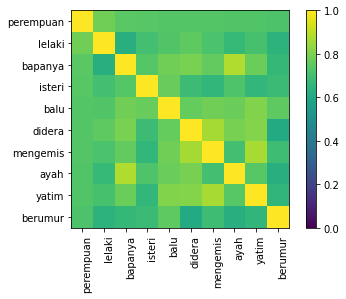

In [16]:
emb_w2v.embset_similar("perempuan", n=10, metric="cosine").plot_similarity()

EmbSet.subset(perempuan,wanita,isteri,gadis,mai,datin,pemudi)

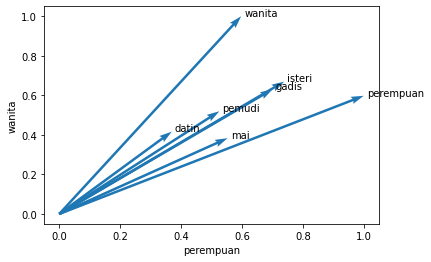

In [29]:
(emb_w2v[female_nouns]
 .plot(x_axis="perempuan", 
       y_axis="wanita", 
       axis_metric="cosine_similarity"))

### Identify bias vector

In [229]:
# Import adjectives from pos tagging
adjs_pos = os.listdir('../adj/')
print(adjs_pos)

['adj_1990', 'adj_1991', 'adj_1994', 'adj_1999', 'adj_2001', 'adj_2004', 'adj_2007', 'adj_2009', 'adj_2014', 'adj_2018', 'adj_2019', 'adj_2020']


In [230]:
adjs = []
for adj in adjs_pos:
    ls = pickle.load(open('../adj/' + adj, 'rb'))
    print(adj, len(ls))
    adjs.extend(ls)
    
print(len(adjs))
print(len(set(adjs)))

adj_1990 4714
adj_1991 15990
adj_1994 15702
adj_1999 11320
adj_2001 14783
adj_2004 12828
adj_2007 15475
adj_2009 14576
adj_2014 12836
adj_2018 14597
adj_2019 14236
adj_2020 10139
157196
63710


In [231]:
adjs = clean_text(' '.join(adjs))
adjs = list(set(adjs))

In [232]:
# Filter adjs so that only adjs existing in all year except 1990 
adjs_none = []

for adj in adjs:
    for year in range(1991, 2021):
        try:
            word2vec_dict_by_year[str(year)].wv[adj]
        except:
            adjs_none.append(adj)
            
adjs_none = list(set(adjs_none))
len(adjs_none)

33827

In [233]:
adjs_fil = [adj for adj in adjs if adj not in adjs_none]
len(adjs_fil)

In [254]:
len(adjs_fil)

4260

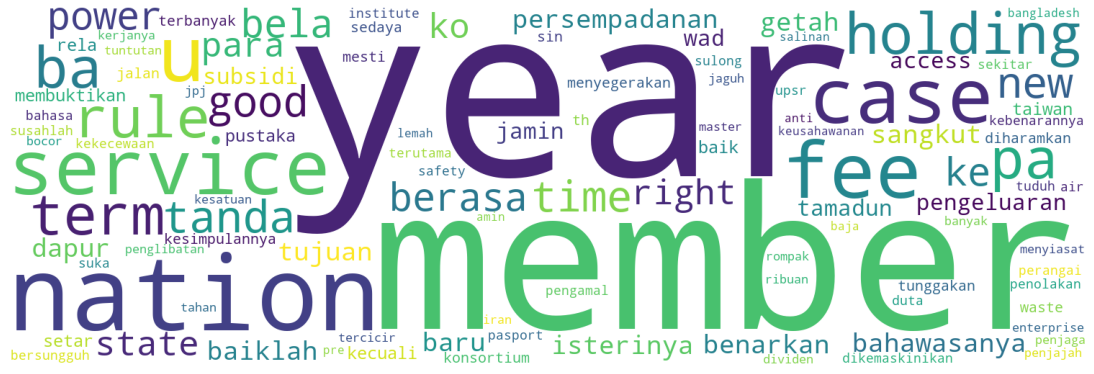

In [239]:
adjs_wc = ' '.join(adjs_fil)
wordcloud = WordCloud(width=1500, height=500, 
                      prefer_horizontal=1,
                      background_color='white', 
                      collocations=False, 
                      min_font_size=15).generate(adjs_wc)

figure, ax = plt.subplots(figsize=(20, 5)) 
ax.imshow(wordcloud)
ax.axis("off") 
figure.tight_layout(pad=0)

In [245]:
adjs_fil[0:500]

['benarkan', 'dapur', 'persempadanan', 'bahawasanya', 'isterinya', 'baru', 'baiklah', 'tujuan', 'getah', 'sangkut', 'pengeluaran', 'tamadun', 'access', 'jamin', 'subsidi', 'wad', 'membuktikan', 'setar', 'rela', 'taiwan', 'kecuali', 'pustaka', 'baik', 'kesimpulannya', 'waste', 'jalan', 'menyegerakan', 'diharamkan', 'th', 'sedaya', 'tunggakan', 'mesti', 'konsortium', 'sin', 'terbanyak', 'kebenarannya', 'safety', 'duta', 'terutama', 'bersungguh', 'dikemaskinikan', 'perangai', 'you', 'air', 'suka', 'sulong', 'susahlah', 'kekecewaan', 'pengamal', 'bahasa', 'institute', 'upsr', 'pasport', 'sekitar', 'penolakan', 'tuduh', 'enterprise', 'tuntutan', 'master', 'penglibatan', 'tahan', 'tercicir', 'year', 'bocor', 'dividen', 'menyiasat', 'iran', 'penjaga', 'jpj', 'kesatuan', 'banyak', 'rompak', 'ribuan', 'penjajah', 'jaguh', 'kerjanya', 'bangladesh', 'lemah', 'anti', 'keusahawanan', 'amin', 'salinan', 'pre', 'baja', 'pertahankan', 'padahal', 'pengesahan', 'mencuri', 'faham', 'beras', 'sungguh', 'i

In [262]:
df_sim_by_year = []

for year in range(1991, 2021):
    adj_similarity = []
    for adj in adjs_manual:
        similarity = word2vec_dict_by_year[str(year)].wv.similarity("wanita", adj)
        adj_similarity.append([adj, similarity])

    df_sim = pd.DataFrame(adj_similarity)
    df_sim.columns = ['word', 'sim']
    df_sim.sort_values(by=['sim'], inplace=True, ascending=False)

    top_adjs = [str(year)]
    top_adjs.extend(df_sim.loc[:, 'word'].head(20).to_list())

    df_sim_by_year.append(top_adjs)
    
df_sim_by_year = pd.DataFrame(df_sim_by_year)

    
df_sim_by_year

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1991,wanita,lelaki,bekerja,menyedarkan,bawahan,berkelayakan,pekerja,sinilah,peri,...,penglibatan,teraniaya,monitoring,suri,syukur,berdaftar,kaunseling,pendidik,cipta,dididik
1,1992,wanita,lelaki,bersendirian,cacat,kebajikan,dedikasi,pendidik,permasalahan,etnik,...,menyedarkan,keagamaan,rakyatnya,peri,penerimaan,majmuk,menindas,tetangga,mesej,penjaga
2,1993,wanita,membabitkan,kaum,penagih,setempat,buta,banduan,gadis,tetangga,...,akal,rukun,duta,gila,perseorangan,kewujudan,jagaan,umpama,kedatangan,lemah
3,1994,wanita,badminton,lelaki,bayi,dewasa,dilatih,berkemahiran,pendidik,profesional,...,warga,sukarela,terlatih,kemenangan,calon,keluarga,membesar,psikologi,keprihatinan,kemahiran
4,1995,wanita,gadis,remaja,saling,keluarga,terkecuali,disiplin,maruah,diskriminasi,...,pekerja,berdisiplin,kaum,bawahan,kepercayaan,bangkit,tani,berkaliber,warga,menganggur
5,1996,wanita,kaum,kepimpinan,lelaki,psikologi,sasar,terpelihara,ngo,kesedaran,...,semangat,jantina,sensitiviti,teladan,benci,pemikiran,perkauman,utamakan,warga,kewajipan
6,1997,wanita,lelaki,kaum,tradisi,perempuan,menekan,toleransi,latar,seluruhnya,...,maruah,warisan,pemimpin,kamu,kesaksamaan,liberal,sifat,visi,keluarganya,lapisan
7,1998,wanita,lelaki,gadis,pembuat,kaum,motivasi,penggerak,keluarga,era,...,penyelaras,umbi,persefahaman,beramai,pencapaian,jurang,kewujudan,sambutan,adat,berjadual
8,1999,wanita,lelaki,fahaman,gadis,orang,kaum,cacat,kecewa,moral,...,naib,penasihat,menindas,graduan,jantina,seks,keluarganya,waras,diskriminasi,seorang
9,2000,wanita,kaum,lelaki,teraniaya,sayang,pembelaan,warga,berdosa,ikatan,...,gadis,berkahwin,etnik,remaja,pentingnya,mengira,beza,pengawal,majmuk,kepimpinan


In [280]:
# Manually select words from the above df 
adjs_manual = ['lemah', 'bocor', 'cacat', 'lembut', 'sasar', 'teraniaya', 'bersendirian',
               'muda', 'miskin', 'berkelayakan', 'berkemahiran', 'toleransi', 'berdosa',
               'profesional', 'berkebolehan', 'berkahwin', 'berkaliber', 'liberal', 'cermat',
               'berdikari', 'mahir', 'berdisiplin', 'gila']

#status = ['isteri', 'ibu', 'bayi', ]

occupations = ['penjaga', 'penolong', 'pendidik', 'usahawan', 'pelatih', 'mahasiswa',
              'pengawal', 'pekerja', 'guru', 'pemimpin']

nouns = ['bawahan', 'keluarga', 'masyarakat', 'kepimpinan', 'kekeluargaan', 'pencapaian',
        'kesaksamaan', 'kahwin', 'kanak', 'keikhlasan']

EmbSet.subset(mengandung,berkahwin,hamil,kahwin,dirogol)

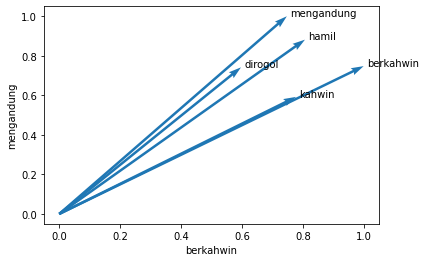

In [35]:
(emb_w2v[status]
 .plot(x_axis='berkahwin', 
       y_axis='mengandung', 
       axis_metric="cosine_similarity"))

### Calculate bias 

- Distance metrics: Euclidean distance, cosine distance 

Personal traits

In [420]:
# Comparsion between wanita and lelaki
year = '2019'
wanita_lelaki = []

adjs_manual = ['lemah', 'cacat', 'lembut', 'sasar', 'teraniaya', 
               'muda', 'berkelayakan', 'berkemahiran', 'berdosa',
               'profesional', 'berkebolehan', 'berkahwin', 'berkaliber', 'cermat',
               'berdikari', 'mahir', 'berdisiplin', 'gila']

adjs_trans = ['lemah(weak)', 'cacat(handicap)', 'lembut(soft)', 'sasar(crazy)', 'teraniaya(humiliated)', 
              'muda(young)', 'berkelayakan(qualified)', 'berkemahiran(skilled)', 'berdosa(sinful)',
              'profesional(professional)', 'berkebolehan(capable)', 'berkahwin(married)', 'berkaliber(caliber)', 'cermat(careful)',
               'berdikari(independent)', 'mahir(skilled)', 'berdisiplin(disciplined)', 'gila(crazy)']

for adj in adjs_manual: 
    sim_w = word2vec_dict_by_year[year].wv.similarity('wanita', adj)
    sim_l = word2vec_dict_by_year[year].wv.similarity('lelaki', adj)
    wanita_lelaki.append([sim_w, sim_l])

df_wl = pd.DataFrame(wanita_lelaki)
df_wl.columns = ['wanita', 'lelaki']
df_wl.head()

,wanita,lelaki
0,0.385186,0.325914
1,0.457582,0.602942
2,0.457573,0.457160
3,0.497909,0.494146
4,0.532319,0.622135


Text(0.5, 1.0, 'The gender similarity with personal traits in 2019')

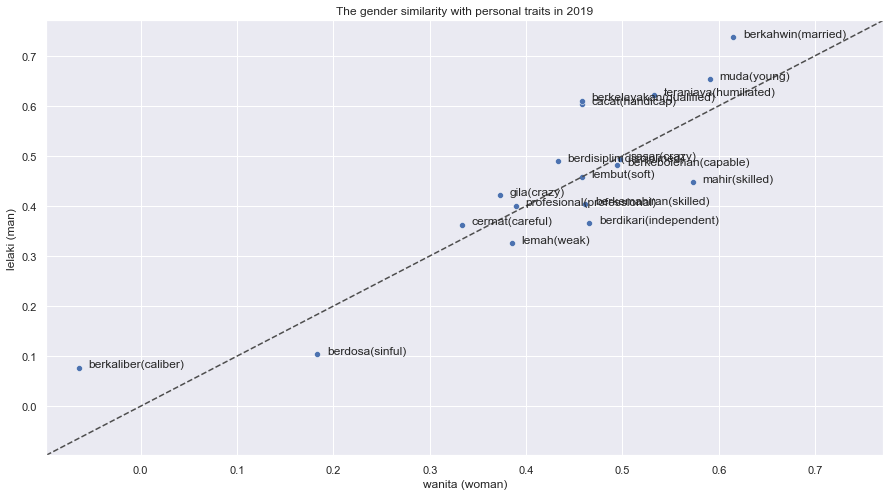

In [421]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(x='wanita', y='lelaki', data=df_wl)
range_axis = list(ax.get_xlim())
range_axis.extend(ax.get_ylim())
range_axis = (min(range_axis), max(range_axis))

ax.set(xlim=range_axis, ylim=range_axis)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']))
        
label_point(df_wl.wanita, df_wl.lelaki, pd.Series(adjs_trans), plt.gca())  

ax.set_xlabel("wanita (woman)")
ax.set_ylabel("lelaki (man)")
ax.set_title("The gender similarity with personal traits in " + year)

In [426]:
# Comparsion between perempuan and lelaki

perem_lelaki = []
for adj in adjs_manual: 
    sim_p = word2vec_dict_by_year[year].wv.similarity('perempuan', adj)
    sim_l = word2vec_dict_by_year[year].wv.similarity('lelaki', adj)
    perem_lelaki.append([sim_p, sim_l])

df_pl = pd.DataFrame(perem_lelaki)
df_pl.columns = ['perempuan', 'lelaki']
df_pl.head()

,perempuan,lelaki
0,0.181339,0.325914
1,0.618234,0.602942
2,0.434981,0.457160
3,0.408456,0.494146
4,0.613191,0.622135


Text(0.5, 1.0, 'The gender similarity with personal traits in 2019')

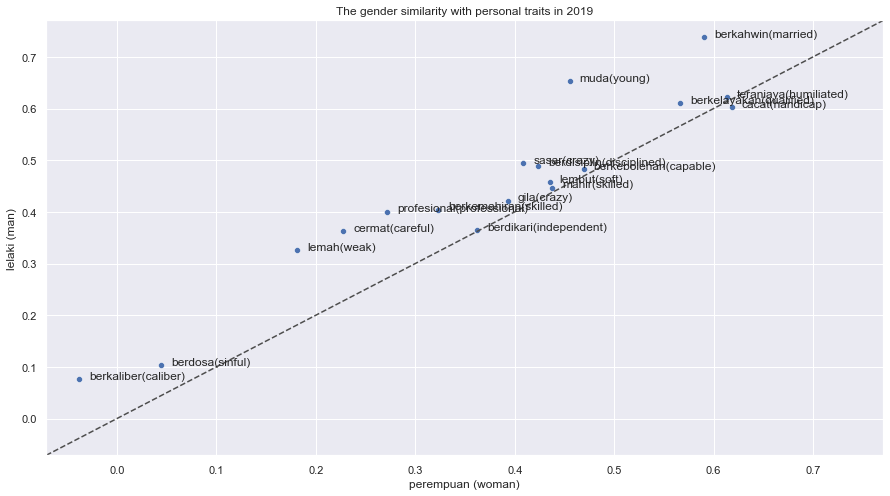

In [427]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(x='perempuan', y='lelaki', data=df_pl)
range_axis = list(ax.get_xlim())
range_axis.extend(ax.get_ylim())
range_axis = (min(range_axis), max(range_axis))

ax.set(xlim=range_axis, ylim=range_axis)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']))
        
label_point(df_pl.perempuan, df_pl.lelaki, pd.Series(adjs_trans), plt.gca())  

ax.set_xlabel("perempuan (woman)")
ax.set_ylabel("lelaki (man)")
ax.set_title("The gender similarity with personal traits in " + year)

Occupations

In [380]:
occupations = ['penjaga', 'penolong', 'pendidik', 'usahawan', 'pelatih', 'mahasiswa',
              'pengawal', 'pekerja', 'guru', 'pemimpin']

occupations_trans = ['penjaga(security)', 'penolong(assistant)', 'pendidik(educator)', 
                     'usahawan(entrepreneurs)', 'pelatih(trainer)', 'mahasiswa(college student)',
                     'pengawal(guards)', 'pekerja(worker)', 'guru(teacher)', 'pemimpin(leader)']

In [381]:
# Comparsion between wanita and lelaki

wanita_lelaki = []

for occ in occupations: 
    sim_w = word2vec_dict_by_year[year].wv.similarity('wanita', occ)
    sim_l = word2vec_dict_by_year[year].wv.similarity('lelaki', occ)
    wanita_lelaki.append([sim_w, sim_l])

df_wl = pd.DataFrame(wanita_lelaki)
df_wl.columns = ['wanita', 'lelaki']
df_wl.head()

,wanita,lelaki
0,0.573601,0.565442
1,0.453213,0.499968
2,0.616460,0.677581
3,0.315980,0.272614
4,0.473932,0.575496


Text(0.5, 1.0, 'The gender similarity with occupations in 1991')

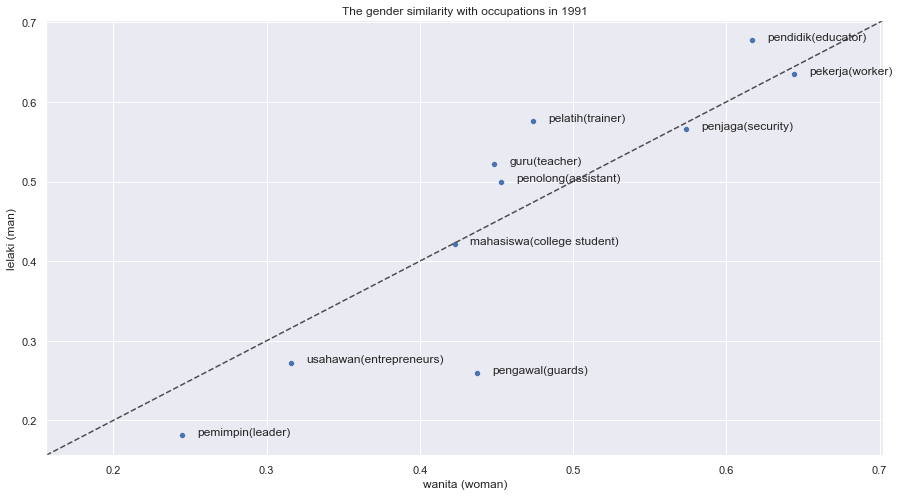

In [382]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(x='wanita', y='lelaki', data=df_wl)
range_axis = list(ax.get_xlim())
range_axis.extend(ax.get_ylim())
range_axis = (min(range_axis), max(range_axis))

ax.set(xlim=range_axis, ylim=range_axis)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']))
        
label_point(df_wl.wanita, df_wl.lelaki, pd.Series(occupations_trans), plt.gca())  

ax.set_xlabel("wanita (woman)")
ax.set_ylabel("lelaki (man)")
ax.set_title("The gender similarity with occupations in " + year)

In [428]:
# Comparsion between perempuan and lelaki

perem_lelaki = []
for occ in occupations: 
    sim_p = word2vec_dict_by_year[year].wv.similarity('perempuan', occ)
    sim_l = word2vec_dict_by_year[year].wv.similarity('lelaki', occ)
    perem_lelaki.append([sim_p, sim_l])

df_pl = pd.DataFrame(perem_lelaki)
df_pl.columns = ['perempuan', 'lelaki']
df_pl.head()

,perempuan,lelaki
0,0.600387,0.583656
1,0.479218,0.491711
2,0.635921,0.674967
3,0.264219,0.357573
4,0.390412,0.505868


Text(0.5, 1.0, 'The gender similarity with occupations in 2019')

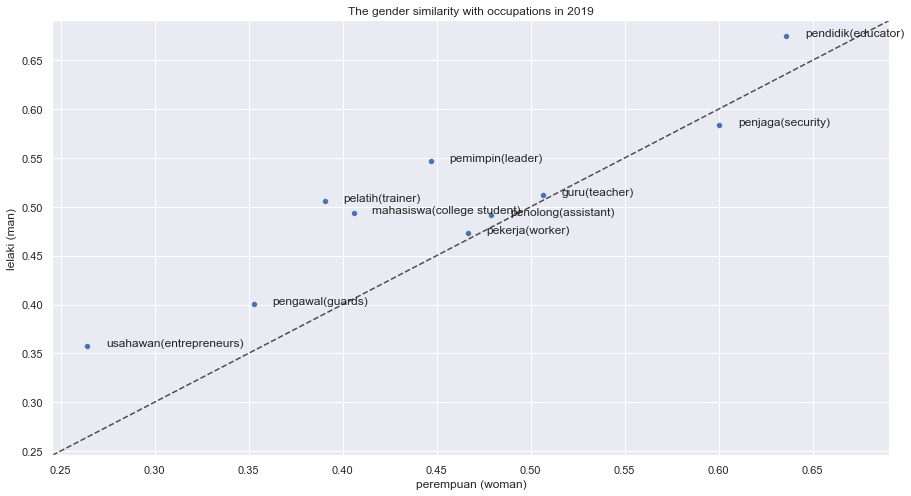

In [429]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(x='perempuan', y='lelaki', data=df_pl)
range_axis = list(ax.get_xlim())
range_axis.extend(ax.get_ylim())
range_axis = (min(range_axis), max(range_axis))

ax.set(xlim=range_axis, ylim=range_axis)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']))
        
label_point(df_pl.perempuan, df_pl.lelaki, pd.Series(occupations_trans), plt.gca())  

ax.set_xlabel("perempuan (woman)")
ax.set_ylabel("lelaki (man)")
ax.set_title("The gender similarity with occupations in " + year)

Compute bias

In [274]:
def get_average_distance(vec1, vec2, embeddings):
    '''Return the average cosine distance between two lists of vectors'''
    cosine_dist = [1-embeddings.wv.similarity(x, y) for x in vec1 for y in vec2]
    return sum(cosine_dist)/len(cosine_dist)

In [385]:
bias_adjs = []

adjs_manual = ['lemah', 'cacat', 'lembut', 'sasar', 'teraniaya', 
               'muda', 'berkelayakan', 'berkemahiran', 'berdosa',
               'profesional', 'berkebolehan', 'berkahwin', 'berkaliber', 'cermat',
               'berdikari', 'mahir', 'berdisiplin', 'gila']

for year in range(1991, 2021):
    dist_female = get_average_distance(['wanita'], adjs_manual, word2vec_dict_by_year[str(year)])
    dist_male = get_average_distance(['lelaki'], adjs_manual, word2vec_dict_by_year[str(year)])
    bias_adjs.append(['lelaki', str(year), dist_male])
    bias_adjs.append(['wanita', str(year), dist_female])
    
df_adjs = pd.DataFrame(bias_adjs)
df_adjs.columns = ['word', 'year', 'dist']
df_adjs.head()

,word,year,dist
0,lelaki,1991,0.490340
1,wanita,1991,0.479515
2,lelaki,1992,0.493125
3,wanita,1992,0.491329
4,lelaki,1993,0.455265


Text(0.5, 1.0, 'The personal traits distance over time')

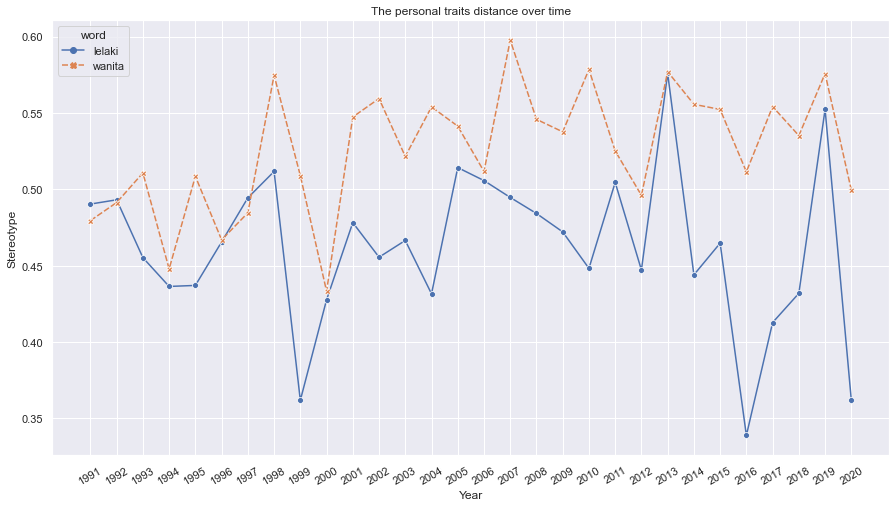

In [386]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='dist', style='word',
             hue='word', markers=True, data=df_adjs)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Stereotype")
ax.set_title("The personal traits distance over time")

In [387]:
bias_occu = []

occupations = ['penjaga', 'penolong', 'pendidik', 'usahawan', 'pelatih', 'mahasiswa',
              'pengawal', 'pekerja', 'guru', 'pemimpin']

for year in range(1991, 2021):
    dist_female = get_average_distance(['wanita'], occupations, word2vec_dict_by_year[str(year)])
    dist_male = get_average_distance(['lelaki'], occupations, word2vec_dict_by_year[str(year)])
    bias_occu.append(['lelaki', str(year), dist_male])
    bias_occu.append(['wanita', str(year), dist_female])
    
df_occu = pd.DataFrame(bias_occu)
df_occu.columns = ['word', 'year', 'dist']
df_occu.head()

,word,year,dist
0,lelaki,1991,0.539028
1,wanita,1991,0.536960
2,lelaki,1992,0.493113
3,wanita,1992,0.446227
4,lelaki,1993,0.533207


Text(0.5, 1.0, 'The occupational distance over time')

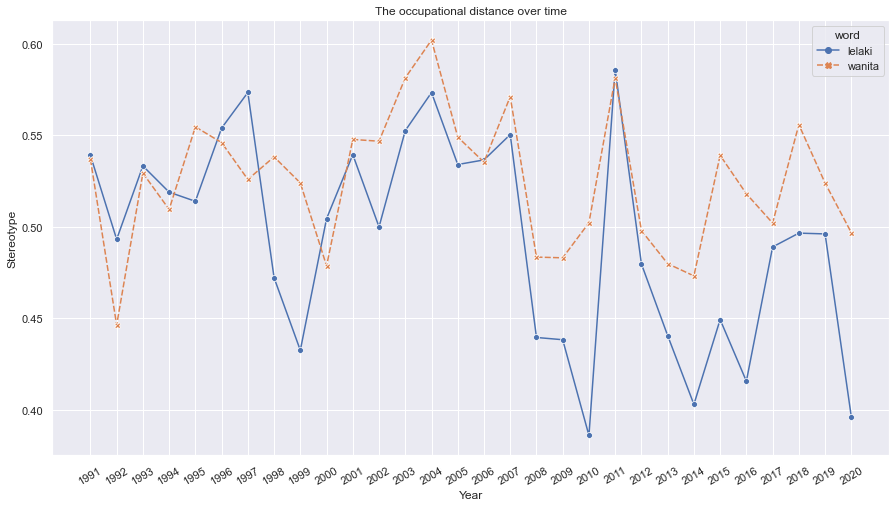

In [388]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='dist', style='word',
             hue='word', markers=True, data=df_occu)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Stereotype")
ax.set_title("The occupational distance over time")

In [389]:
bias_adjs = []

female_nouns = ['perempuan', 'wanita', 'gadis']
male_nouns = ['lelaki', 'pemuda']

for year in range(1991, 2021):
    dist_female = get_average_distance(female_nouns, adjs_manual, word2vec_dict_by_year[str(year)])
    dist_male = get_average_distance(male_nouns, adjs_manual, word2vec_dict_by_year[str(year)])
    bias_adjs.append(['male', str(year), dist_male])
    bias_adjs.append(['female', str(year), dist_female])
    
df_adjs = pd.DataFrame(bias_adjs)
df_adjs.columns = ['word', 'year', 'dist']
df_adjs.head()

,word,year,dist
0,male,1991,0.560928
1,female,1991,0.542006
2,male,1992,0.501396
3,female,1992,0.502048
4,male,1993,0.490442


Text(0.5, 1.0, 'The personal traits distance over time')

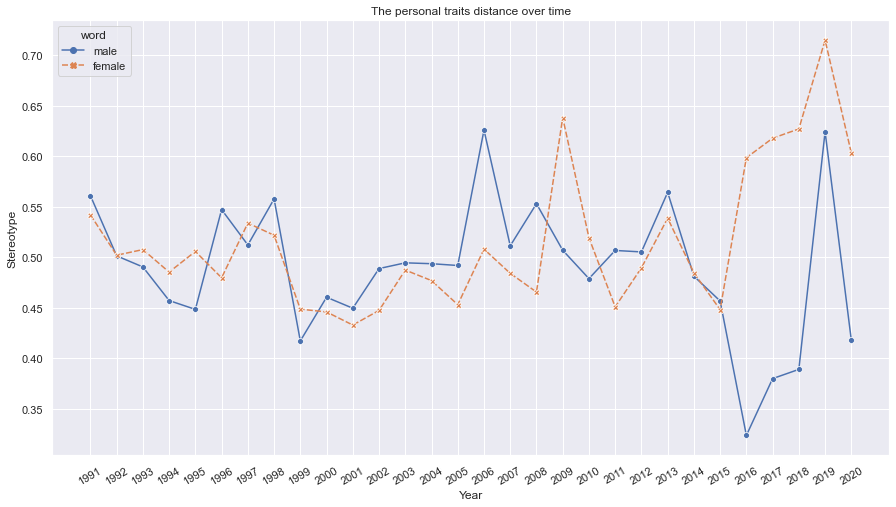

In [390]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='dist', style='word',
             hue='word', markers=True, data=df_adjs)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Stereotype")
ax.set_title("The personal traits distance over time")

In [291]:
bias_occu = []

for year in range(1991, 2021):
    dist_female = get_average_distance(female_nouns, occupations, word2vec_dict_by_year[str(year)])
    dist_male = get_average_distance(male_nouns, occupations, word2vec_dict_by_year[str(year)])
    bias_occu.append(['male', str(year), dist_male])
    bias_occu.append(['female', str(year), dist_female])
    
df_occu = pd.DataFrame(bias_occu)
df_occu.columns = ['word', 'year', 'dist']
df_occu.head()

,word,year,dist
0,male,1991,0.596213
1,female,1991,0.570079
2,male,1992,0.493382
3,female,1992,0.488040
4,male,1993,0.535364


Text(0.5, 1.0, 'The occupational distance over time')

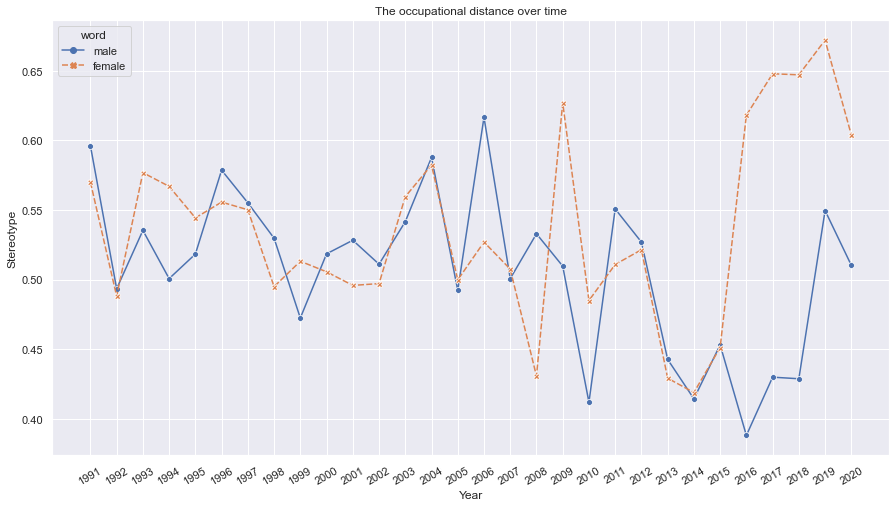

In [292]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='dist', style='word',
             hue='word', markers=True, data=df_occu)

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Stereotype")
ax.set_title("The occupational distance over time")

In [395]:
bias_adjs = []

adjs_manual = ['lemah', 'cacat', 'lembut', 'sasar', 'teraniaya', 
               'muda', 'berkelayakan', 'berkemahiran', 'berdosa',
               'profesional', 'berkebolehan', 'berkahwin', 'berkaliber', 'cermat',
               'berdikari', 'mahir', 'berdisiplin', 'gila']

for year in range(1991, 2021):
    dist_female = get_average_distance(['wanita'], adjs_manual, word2vec_dict_by_year[str(year)])
    dist_male = get_average_distance(['lelaki'], adjs_manual, word2vec_dict_by_year[str(year)])
    bias = dist_female - dist_male
    bias_adjs.append([str(year), bias])
    
df_adjs = pd.DataFrame(bias_adjs)
df_adjs['MA'] = df_adjs.iloc[:, 1].rolling(window=5).mean()
df_adjs.columns = ['year', 'bias', 'MA']
df_adjs.head()

,year,bias,MA
0,1991,-0.010825,NaN
1,1992,-0.001796,NaN
2,1993,0.055442,NaN
3,1994,0.011446,NaN
4,1995,0.071412,0.025136


Text(0.5, 1.0, 'The personal traits stereotypes over time')

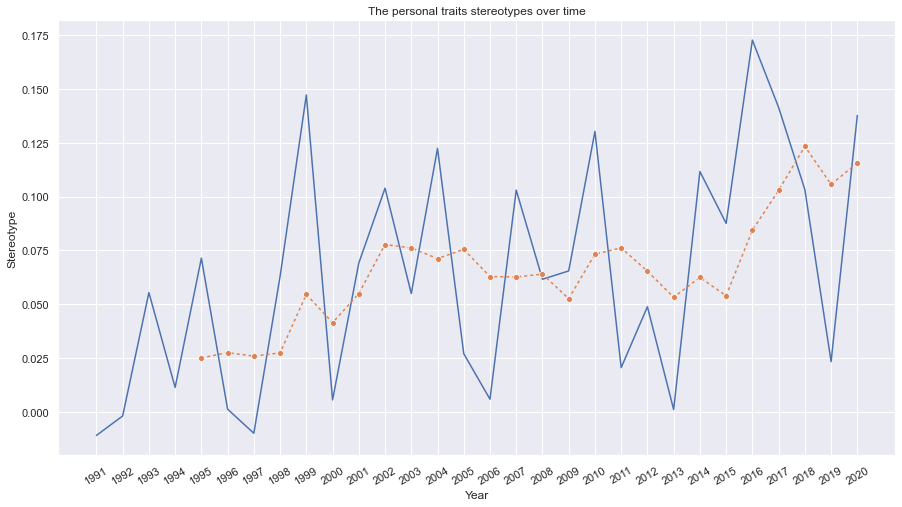

In [409]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='bias', markers=True, data=df_adjs)
sns.lineplot(x='year', y='MA', markers=True, style=True, dashes=[(2,2)], data=df_adjs)
ax.get_legend().remove()

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Stereotype")
ax.set_title("The personal traits stereotypes over time")

In [410]:
bias_occu = []

occupations = ['penjaga', 'penolong', 'pendidik', 'usahawan', 'pelatih', 'mahasiswa',
              'pengawal', 'pekerja', 'guru', 'pemimpin']

for year in range(1991, 2021):
    dist_female = get_average_distance(['wanita'], occupations, word2vec_dict_by_year[str(year)])
    dist_male = get_average_distance(['lelaki'], occupations, word2vec_dict_by_year[str(year)])
    bias = dist_female - dist_male
    bias_occu.append([str(year), bias])
    
df_occu = pd.DataFrame(bias_occu)
df_occu['MA'] = df_occu.iloc[:, 1].rolling(window=5).mean()
df_occu.columns = ['year', 'bias', 'MA']
df_occu.head()

,year,bias,MA
0,1991,-0.002068,NaN
1,1992,-0.046886,NaN
2,1993,-0.003910,NaN
3,1994,-0.009459,NaN
4,1995,0.040688,-0.004327


Text(0.5, 1.0, 'The occupational stereotypes over time')

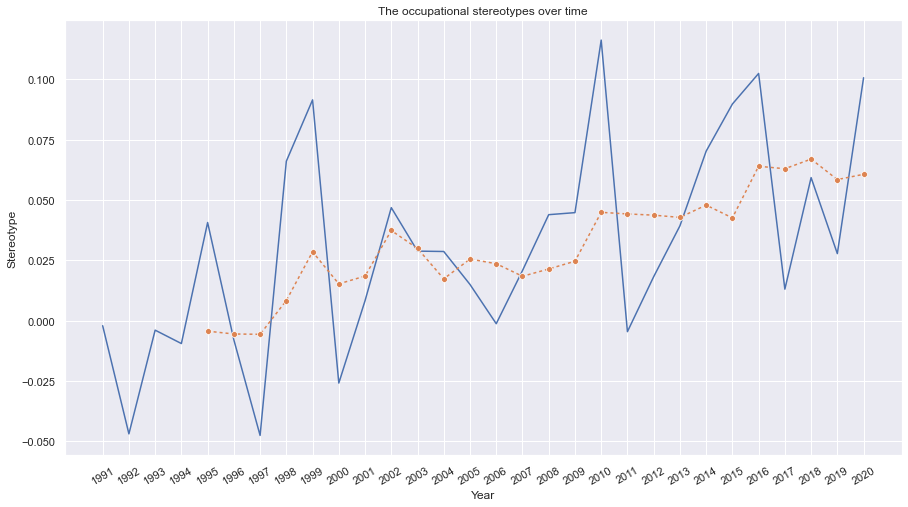

In [411]:
figure, ax = plt.subplots(figsize=(15, 8))

sns.lineplot(x='year', y='bias', markers=True, data=df_occu)
sns.lineplot(x='year', y='MA', markers=True, style=True, dashes=[(2,2)], data=df_occu)
ax.get_legend().remove()

plt.xticks(rotation=30)
ax.set_xlabel("Year")
ax.set_ylabel("Stereotype")
ax.set_title("The occupational stereotypes over time")